HW5 -- Dave Foote

5/29/2019

In [57]:
%load_ext autoreload
%autoreload 2
import os
import ml_loop as ml
import model_analyzer as ma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from IPython.display import Image, display
import warnings


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read Data:

In [4]:
df = ml.read_csv_handledates('data/projects_2012_2013.csv', ['date_posted', 'datefullyfunded'])

Time to do some imputations and generate my outcome variable:

In [5]:
df.isnull().sum()

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

Some of these would make sense to populate with the mode, others would be best left NaNs and given their own NaN dummy column later in the process.

In [6]:
mode_impute_list = ['school_metro', 'resource_type', 'primary_focus_subject',
                   'primary_focus_area']

In [7]:
ml.fillna_modal(df, mode_impute_list)

In [8]:
ml.calculate_duration(df, 'date_posted', 'datefullyfunded', 'duration')

In [9]:
ml.compare_tdelta_generate_binary(df, 'duration', '60 days', 'Y')

Wanna check and see that 1's represent rows with durations <= 60 days

In [10]:
df[['duration', 'Y']]

duration  Y
0       18 days  1
1       11 days  1
2       76 days  0
3       55 days  1
4       76 days  0
5       88 days  0
6       22 days  1
7       10 days  1
8       23 days  1
9       31 days  1
10     120 days  0
11     117 days  0
12      37 days  1
13      33 days  1
14     101 days  0
15      44 days  1
16     112 days  0
17      55 days  1
18      28 days  1
19      21 days  1
20      19 days  1
21      53 days  1
22     113 days  0
23      78 days  0
24      30 days  1
25     118 days  0
26      67 days  0
27      40 days  1
28      43 days  1
29      74 days  0
...         ... ..
124946  13 days  1
124947  13 days  1
124948  44 days  1
124949  67 days  0
124950  93 days  0
124951  76 days  0
124952 114 days  0
124953  41 days  1
124954  37 days  1
124955  37 days  1
124956  37 days  1
124957  37 days  1
124958  23 days  1
124959  23 days  1
124960   8 days  1
124961  25 days  1
124962  10 days  1
124963  20 days  1
124964  47 days  1
124965  12 days  1
124966  55 days  1
124967  95 days  0
124968  66 days  0
124969 103 days  0
124970 120 days  0
124971  36 days  1
124972  56 days  1
124973  45 days  1
124974  15 days  1
124975  47 days  1

[124976 rows x 2 columns]

In [11]:
df['students_reached'] = df.students_reached.astype('float64')

Data Exploration

In [12]:
df.describe()

school_ncesid  school_latitude  school_longitude  \
count   1.157430e+05    124976.000000     124976.000000   
mean    2.448448e+11        36.827284        -95.859299   
std     1.644728e+11         4.963669         18.392876   
min     1.000050e+10        18.249140       -171.690554   
25%     6.344101e+10        33.872504       -117.806418   
50%     2.200870e+11        36.617410        -90.101563   
75%     3.704880e+11        40.676156        -80.713740   
max     6.100010e+11        65.672562        -66.628036   

       total_price_including_optional_support  students_reached  \
count                           124976.000000     124917.000000   
mean                               654.011811         95.445760   
std                               1098.015854        163.481912   
min                                 92.000000          1.000000   
25%                                345.810000         23.000000   
50%                                510.500000         30.000000   
75%                                752.960000        100.000000   
max                             164382.840000      12143.000000   

                      duration              Y  
count                   124976  124976.000000  
mean   48 days 08:23:55.437203       0.711865  
std    31 days 23:57:09.256424       0.452896  
min            5 days 00:00:00       0.000000  
25%           23 days 00:00:00       0.000000  
50%           41 days 00:00:00       1.000000  
75%           72 days 00:00:00       1.000000  
max          120 days 00:00:00       1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f4de278>,
      dtype=object)

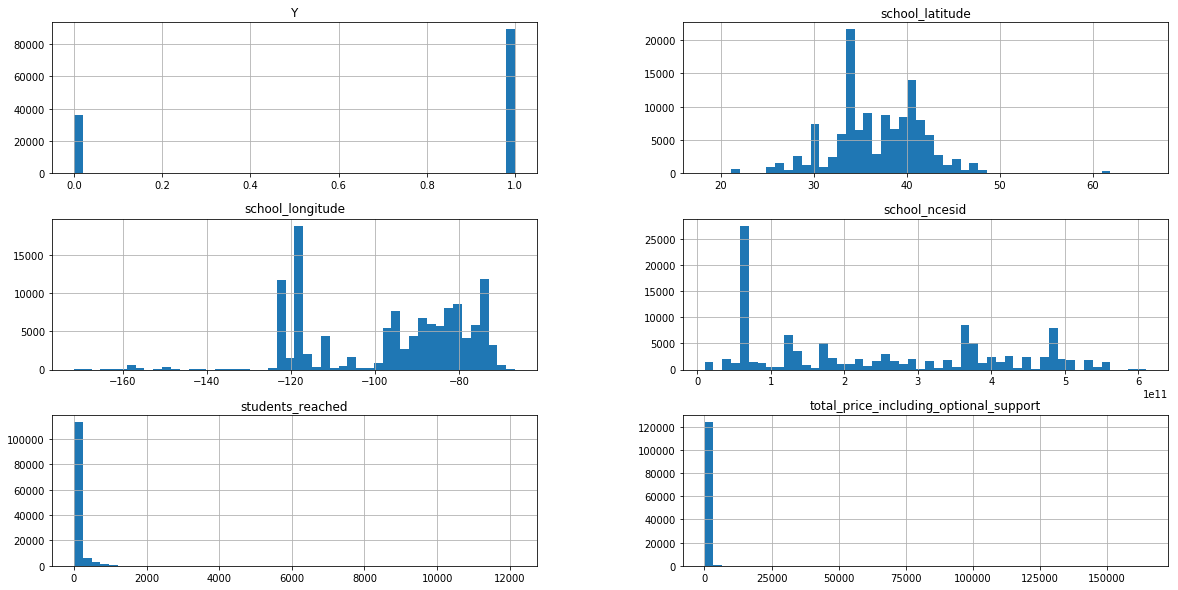

In [13]:
df.hist(figsize=(20,10), bins=50)

Feature Generation / Data Exploration Continued

In [14]:
#lets identify the string and float columns per the lab
strcols, fltcols = ml.id_potential_features(df)
print('strings: ', strcols)
print('floats: ', fltcols)

strings:  ['school_metro', 'school_charter', 'school_magnet', 'teacher_prefix', 'primary_focus_area', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'eligible_double_your_impact_match']
floats:  ['school_ncesid', 'school_latitude', 'school_longitude', 'total_price_including_optional_support', 'students_reached']


But we I don't want lat and long or school id as features, because they are both unique identifiers of a school that are not easily convertible into features.

In [15]:
fltcols.remove('school_latitude')
fltcols.remove('school_longitude')
fltcols.remove('school_ncesid')
print(fltcols)

['total_price_including_optional_support', 'students_reached']


Ok gonna impute 'students reached' with its mean, because its hard to understand why a project would not impact any students.

In [16]:
ml.fillzero_mean(df, 'students_reached')

In [17]:
df['duration_flt'] = df.duration.astype('timedelta64[D]')

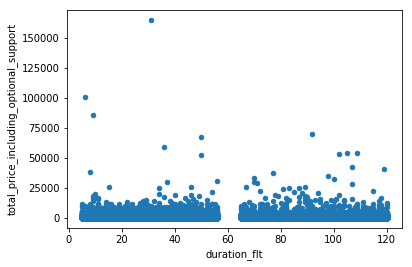

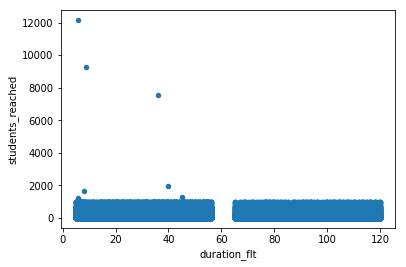

In [18]:
for c in fltcols:
    df.plot(kind='scatter', x='duration_flt', y=c)

In [19]:
features = ml.strings_to_dummies(df, strcols)

In [20]:
#add the discretized floats
ml.add_discretized_float_cols(df, features, fltcols)

In [21]:
features.columns

Index(['school_metro_suburban', 'school_metro_urban', 'school_metro_nan',
       'school_charter_t', 'school_charter_nan', 'school_magnet_t',
       'school_magnet_nan', 'teacher_prefix_Mr.', 'teacher_prefix_Mrs.',
       'teacher_prefix_Ms.', 'teacher_prefix_nan',
       'primary_focus_area_Health & Sports',
       'primary_focus_area_History & Civics',
       'primary_focus_area_Literacy & Language',
       'primary_focus_area_Math & Science',
       'primary_focus_area_Music & The Arts',
       'primary_focus_area_Special Needs', 'primary_focus_area_nan',
       'secondary_focus_area_Health & Sports',
       'secondary_focus_area_History & Civics',
       'secondary_focus_area_Literacy & Language',
       'secondary_focus_area_Math & Science',
       'secondary_focus_area_Music & The Arts',
       'secondary_focus_area_Special Needs', 'secondary_focus_area_nan',
       'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       '

more features, aggregated features

In [22]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'duration', 'Y', 'duration_flt'],
      dtype='object')

In [23]:
features.head()

school_metro_suburban  school_metro_urban  school_metro_nan  \
0                      0                   1                 0   
1                      0                   1                 0   
2                      0                   1                 0   
3                      0                   1                 0   
4                      1                   0                 0   

   school_charter_t  school_charter_nan  school_magnet_t  school_magnet_nan  \
0                 0                   0                0                  0   
1                 0                   0                0                  0   
2                 0                   0                0                  0   
3                 0                   0                1                  0   
4                 0                   0                0                  0   

   teacher_prefix_Mr.  teacher_prefix_Mrs.  teacher_prefix_Ms.  ...  \
0                   0                    1                   0  ...   
1                   0                    1                   0  ...   
2                   0                    0                   1  ...   
3                   0                    0                   1  ...   
4                   0                    1                   0  ...   

   grade_level_Grades 6-8  grade_level_Grades 9-12  grade_level_Grades PreK-2  \
0                       0                        0                          1   
1                       0                        0                          0   
2                       0                        0                          0   
3                       0                        0                          1   
4                       0                        0                          1   

   grade_level_nan  eligible_double_your_impact_match_t  \
0                0                                    0   
1                0                                    1   
2                0                                    0   
3                0                                    0   
4                0                                    0   

   eligible_double_your_impact_match_nan  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   total_price_including_optional_support  \
0                                 1498.61   
1                                  282.47   
2                                 1012.38   
3                                  175.33   
4                                 3591.11   

   total_price_including_optional_support_d  students_reached  \
0                                      high              31.0   
1                                       low              28.0   
2                                      high              56.0   
3                                       low              23.0   
4                                      high             150.0   

   students_reached_d  
0         medium high  
1          medium low  
2         medium high  
3                 low  
4                high  

[5 rows x 45 columns]

In [24]:
features['cheap_high_impact'] = np.where((features['total_price_including_optional_support'] < 500) &
                                        (features['students_reached'] > 30), 1, 0)

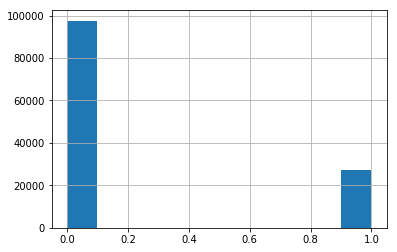

In [25]:
features['cheap_high_impact'].hist()

In [26]:
features['dollar_per_student'] = df['total_price_including_optional_support'] / df['students_reached']

In [27]:
features['dollar_per_student'].fillna(0, inplace = True)

In [28]:
ml.fillzero_mean(features, 'dollar_per_student')

In [29]:
x = features.dollar_per_student.max()
y = features.dollar_per_student.min()
z = features.dollar_per_student.mean()

print('max $ per student: ', x)
print('min $ per student: ', y)
print('mean $ per student: ', z)

max $ per student:  4821.96
min $ per student:  0.16097097097097096
mean $ per student:  20.15099257065847


In [30]:
ml.add_discretized_float_cols(features, features, ['dollar_per_student'])

In [31]:
features.dollar_per_student_d.unique()

[high, medium low, medium high, low]
Categories (4, object): [low < medium low < medium high < high]

In [32]:
df['dollar_per_student'] = features.dollar_per_student

In [33]:
features.head()

school_metro_suburban  school_metro_urban  school_metro_nan  \
0                      0                   1                 0   
1                      0                   1                 0   
2                      0                   1                 0   
3                      0                   1                 0   
4                      1                   0                 0   

   school_charter_t  school_charter_nan  school_magnet_t  school_magnet_nan  \
0                 0                   0                0                  0   
1                 0                   0                0                  0   
2                 0                   0                0                  0   
3                 0                   0                1                  0   
4                 0                   0                0                  0   

   teacher_prefix_Mr.  teacher_prefix_Mrs.  teacher_prefix_Ms.  ...  \
0                   0                    1                   0  ...   
1                   0                    1                   0  ...   
2                   0                    0                   1  ...   
3                   0                    0                   1  ...   
4                   0                    1                   0  ...   

   grade_level_nan  eligible_double_your_impact_match_t  \
0                0                                    0   
1                0                                    1   
2                0                                    0   
3                0                                    0   
4                0                                    0   

   eligible_double_your_impact_match_nan  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   total_price_including_optional_support  \
0                                 1498.61   
1                                  282.47   
2                                 1012.38   
3                                  175.33   
4                                 3591.11   

   total_price_including_optional_support_d  students_reached  \
0                                      high              31.0   
1                                       low              28.0   
2                                      high              56.0   
3                                       low              23.0   
4                                      high             150.0   

   students_reached_d  cheap_high_impact  dollar_per_student  \
0         medium high                  0           48.342258   
1          medium low                  0           10.088214   
2         medium high                  0           18.078214   
3                 low                  0            7.623043   
4                high                  0           23.940733   

   dollar_per_student_d  
0                  high  
1            medium low  
2           medium high  
3            medium low  
4           medium high  

[5 rows x 48 columns]

In [34]:
features.describe()

school_metro_suburban  school_metro_urban  school_metro_nan  \
count          124976.000000       124976.000000          124976.0   
mean                0.264723            0.620047               0.0   
std                 0.441187            0.485377               0.0   
min                 0.000000            0.000000               0.0   
25%                 0.000000            0.000000               0.0   
50%                 0.000000            1.000000               0.0   
75%                 1.000000            1.000000               0.0   
max                 1.000000            1.000000               0.0   

       school_charter_t  school_charter_nan  school_magnet_t  \
count     124976.000000            124976.0    124976.000000   
mean           0.093106                 0.0         0.085640   
std            0.290582                 0.0         0.279833   
min            0.000000                 0.0         0.000000   
25%            0.000000                 0.0         0.000000   
50%            0.000000                 0.0         0.000000   
75%            0.000000                 0.0         0.000000   
max            1.000000                 0.0         1.000000   

       school_magnet_nan  teacher_prefix_Mr.  teacher_prefix_Mrs.  \
count           124976.0       124976.000000        124976.000000   
mean                 0.0            0.130209             0.481612   
std                  0.0            0.336535             0.499664   
min                  0.0            0.000000             0.000000   
25%                  0.0            0.000000             0.000000   
50%                  0.0            0.000000             0.000000   
75%                  0.0            0.000000             1.000000   
max                  0.0            1.000000             1.000000   

       teacher_prefix_Ms.  ...  grade_level_Grades 6-8  \
count       124976.000000  ...           124976.000000   
mean             0.388163  ...                0.171865   
std              0.487334  ...                0.377265   
min              0.000000  ...                0.000000   
25%              0.000000  ...                0.000000   
50%              0.000000  ...                0.000000   
75%              1.000000  ...                0.000000   
max              1.000000  ...                1.000000   

       grade_level_Grades 9-12  grade_level_Grades PreK-2  grade_level_nan  \
count            124976.000000              124976.000000    124976.000000   
mean                  0.132201                   0.381913         0.000024   
std                   0.338711                   0.485857         0.004899   
min                   0.000000                   0.000000         0.000000   
25%                   0.000000                   0.000000         0.000000   
50%                   0.000000                   0.000000         0.000000   
75%                   0.000000                   1.000000         0.000000   
max                   1.000000                   1.000000         1.000000   

       eligible_double_your_impact_match_t  \
count                        124976.000000   
mean                              0.296769   
std                               0.456836   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               1.000000   
max                               1.000000   

       eligible_double_your_impact_match_nan  \
count                               124976.0   
mean                                     0.0   
std                                      0.0   
min                                      0.0   
25%                                      0.0   
50%                                      0.0   
75%                                      0.0   
max                                      0.0   

       total_price_including_optional_support  students_reached  \
count                           1249

In [35]:
features.shape

(124976, 48)

In [36]:
df.shape

(124976, 30)

Now to add dates, split this up, then run some models.

In [37]:
features['date_posted'] = df['date_posted']

In [38]:
features['project_id'] = df['projectid']

In [39]:
features['Y'] = df['Y']

In [40]:
features.date_posted.min()

Timestamp('2012-01-01 00:00:00')

In [41]:
features.date_posted.max()

Timestamp('2013-12-31 00:00:00')

Split Data for Temporal Cross Validation

In [42]:
#lets remove the holdouts and seperate the train/test dates:
tt_periods = ml.temp_holdout(features, 'date_posted', 6, 60)

Show that holdout periods have been maintained:

In [43]:
for i, x in enumerate(tt_periods):
    print('period {}:'.format(i), x['date_posted'].min(), 
         ' - ', x['date_posted'].max())

period 0: 2012-01-01 00:00:00  -  2012-06-30 00:00:00
period 1: 2012-08-30 00:00:00  -  2013-03-01 00:00:00
period 2: 2013-05-01 00:00:00  -  2013-10-31 00:00:00


Now to split up the ids, x's, and y's

In [44]:
tt_periods[0].iloc[:2, [-2, -3]]

project_id date_posted
1  0000fa3aa8f6649abab23615b546016d  2012-04-07
2  000134f07d4b30140d63262c871748ff  2012-01-30

In [45]:
ready_for_modeling = ml.seperate_ids_feats_ys(tt_periods)

(26386, 2)
(26386, 48)
(26386,)
(33505, 2)
(33505, 48)
(33505,)
(38131, 2)
(38131, 48)
(38131,)


In [46]:
ready_for_modeling[0][0].head()

project_id date_posted
1   0000fa3aa8f6649abab23615b546016d  2012-04-07
2   000134f07d4b30140d63262c871748ff  2012-01-30
16  000be0b57987d6c29d650a88eac2961b  2012-01-26
18  000e6a13fd69bf0e426403b1d5da0e99  2012-01-23
23  00105edf14ebb7f146d6ba2098639bb1  2012-04-29

In [47]:
ready_for_modeling[0][1].head()

school_metro_suburban  school_metro_urban  school_metro_nan  \
1                       0                   1                 0   
2                       0                   1                 0   
16                      1                   0                 0   
18                      0                   1                 0   
23                      1                   0                 0   

    school_charter_t  school_charter_nan  school_magnet_t  school_magnet_nan  \
1                  0                   0                0                  0   
2                  0                   0                0                  0   
16                 0                   0                0                  0   
18                 0                   0                0                  0   
23                 0                   0                0                  0   

    teacher_prefix_Mr.  teacher_prefix_Mrs.  teacher_prefix_Ms.  ...  \
1                    0                    1                   0  ...   
2                    0                    0                   1  ...   
16                   0                    0                   1  ...   
18                   0                    0                   1  ...   
23                   0                    1                   0  ...   

    grade_level_nan  eligible_double_your_impact_match_t  \
1                 0                                    1   
2                 0                                    0   
16                0                                    0   
18                0                                    1   
23                0                                    0   

    eligible_double_your_impact_match_nan  \
1                                       0   
2                                       0   
16                                      0   
18                                      0   
23                                      0   

    total_price_including_optional_support  \
1                                   282.47   
2                                  1012.38   
16                                  481.18   
18                                  296.68   
23                                 2130.40   

    total_price_including_optional_support_d  students_reached  \
1                                        low              28.0   
2                                       high              56.0   
16                                medium low             120.0   
18                                       low              30.0   
23                                      high              30.0   

    students_reached_d  cheap_high_impact  dollar_per_student  \
1           medium low                  0           10.088214   
2          medium high                  0           18.078214   
16                high                  1            4.009833   
18          medium low                  0            9.889333   
23          medium low                  0           71.013333   

    dollar_per_student_d  
1             medium low  
2            medium high  
16                   low  
18            medium low  
23                  high  

[5 rows x 48 columns]

In [48]:
ready_for_modeling[0][2].head()

1     1
2     0
16    0
18    1
23    0
Name: Y, dtype: int64

In [60]:
clfs, grid = ml.define_clfs_params('small')

In [50]:
test_feats = ['school_metro_suburban', 'school_metro_urban', 'school_metro_nan',
       'school_charter_t', 'school_charter_nan', 'school_magnet_t',
       'school_magnet_nan', 'teacher_prefix_Mr.', 'teacher_prefix_Mrs.']

In [51]:
train_x = ready_for_modeling[0][1].loc[:, test_feats]
test_x = ready_for_modeling[1][1].loc[:, test_feats]

In [52]:
test_x.shape

(33505, 9)

RF{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

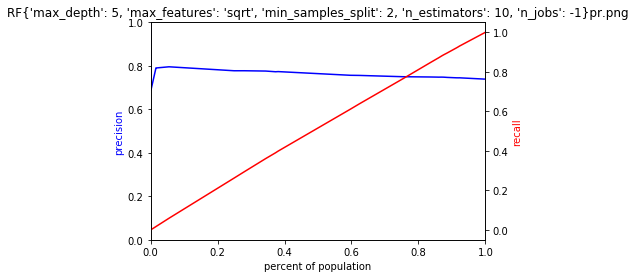

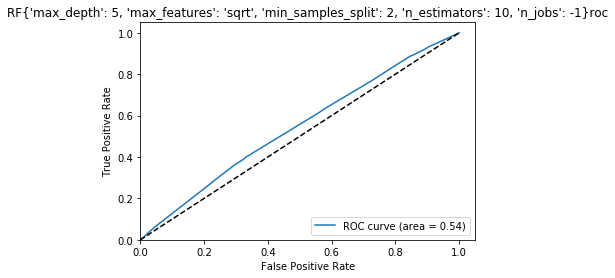

RF{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

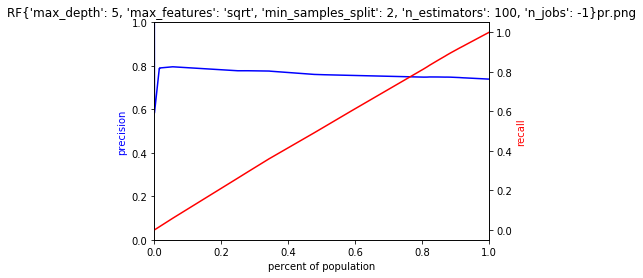

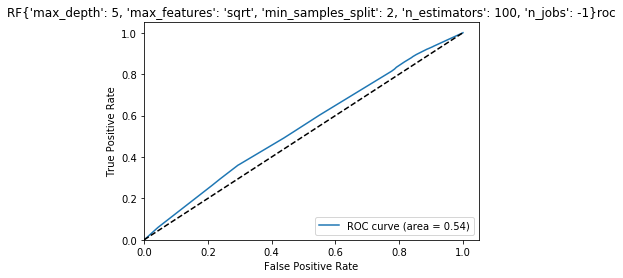

RF{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

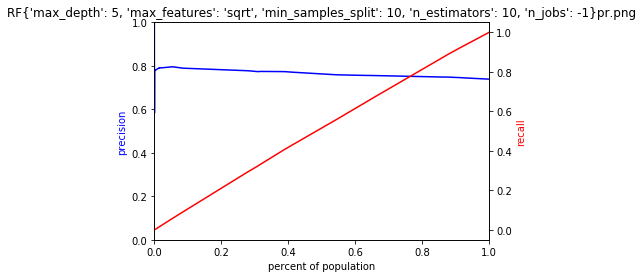

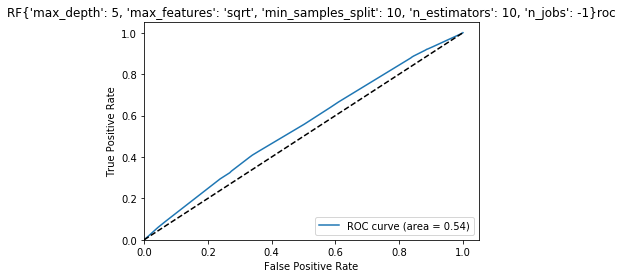

RF{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

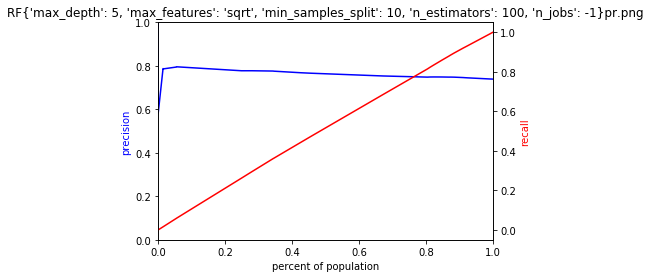

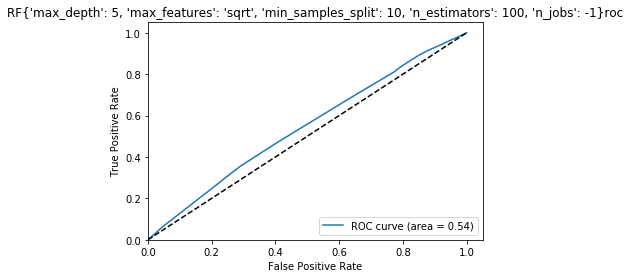

RF{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

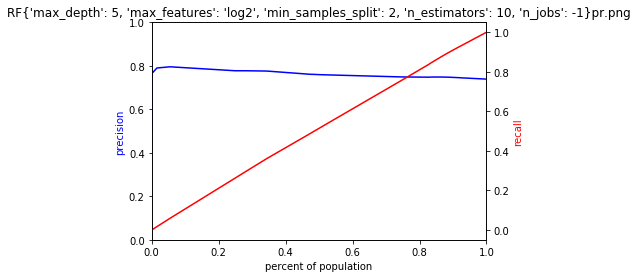

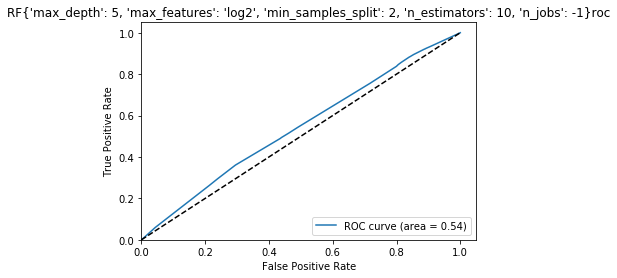

RF{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

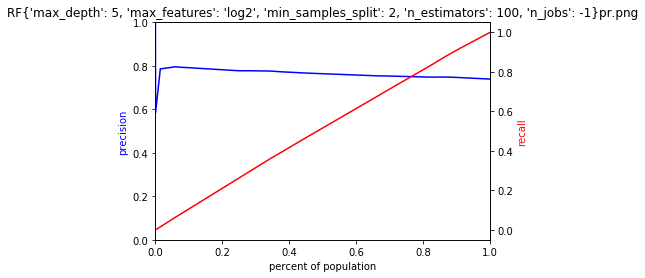

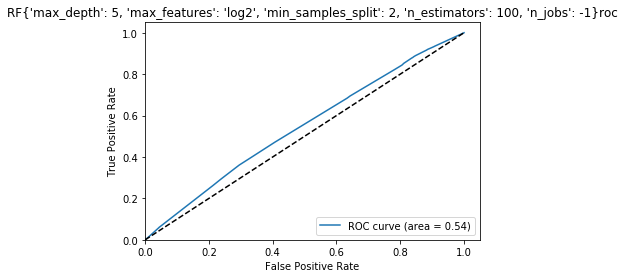

RF{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

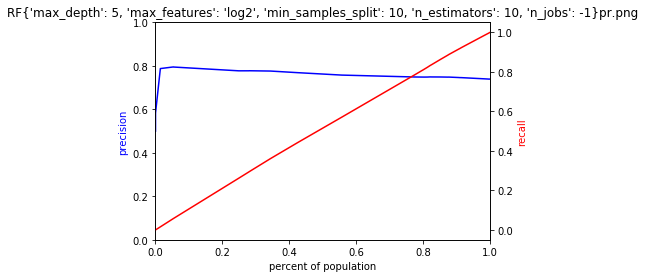

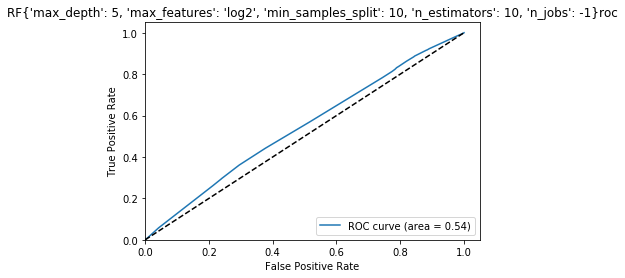

RF{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

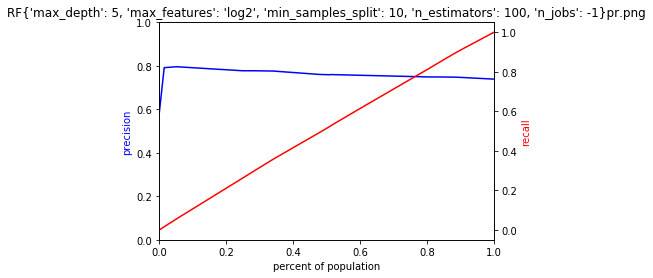

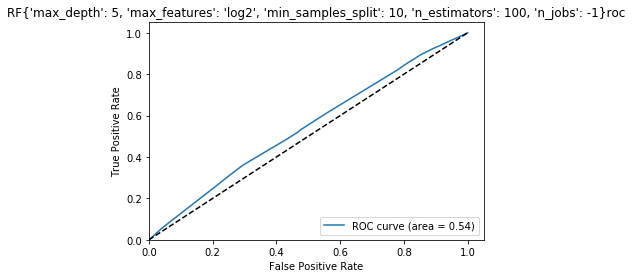

RF{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

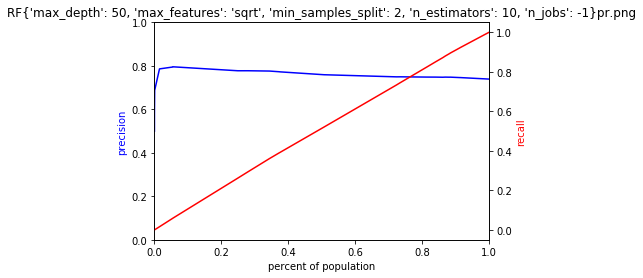

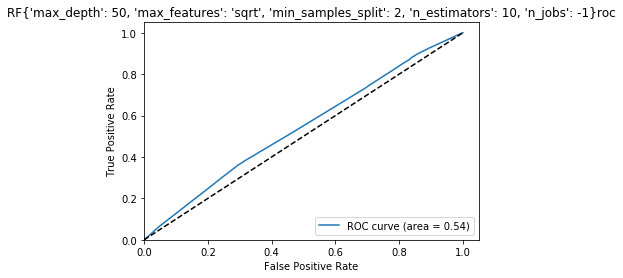

RF{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

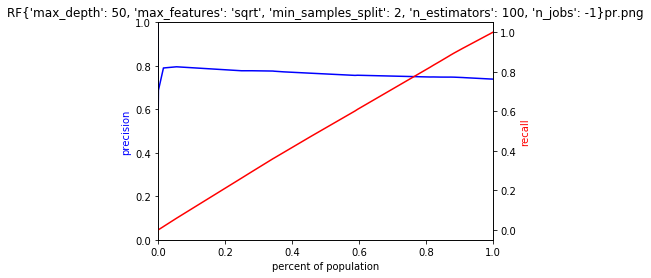

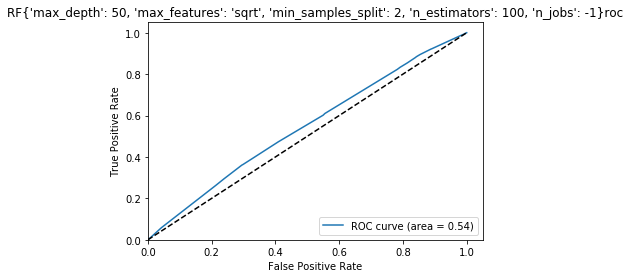

RF{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

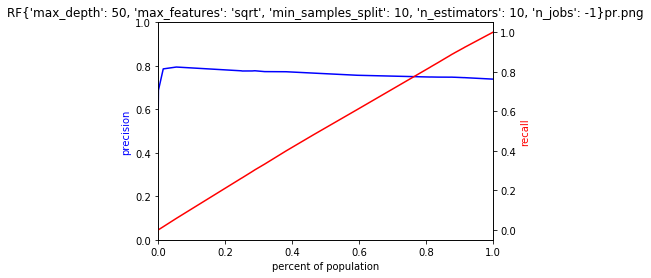

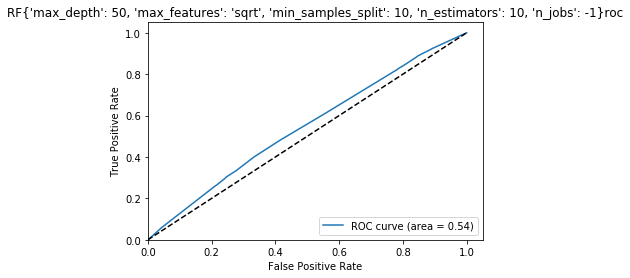

RF{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

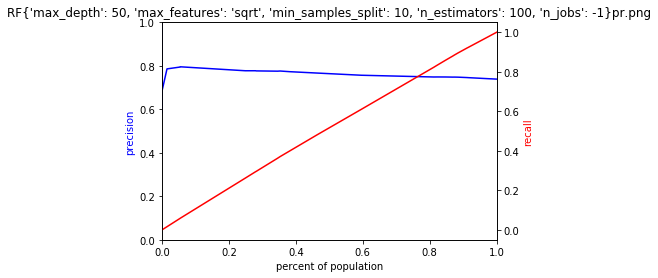

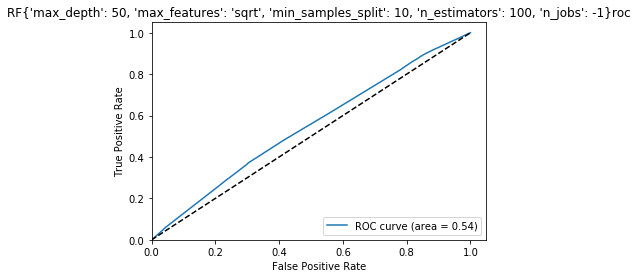

RF{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

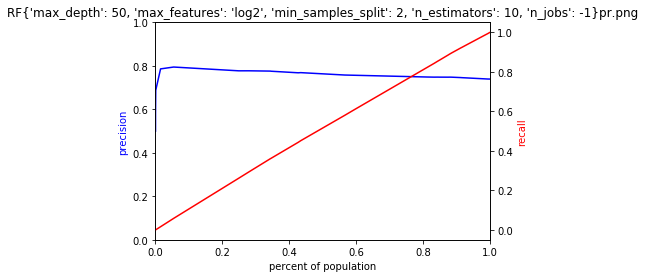

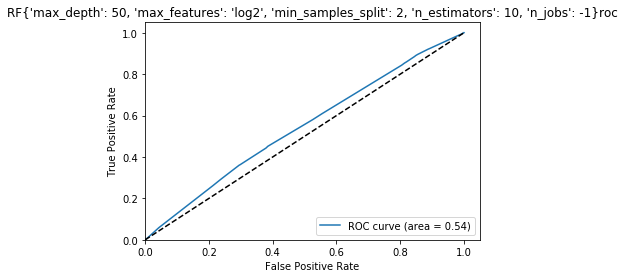

RF{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

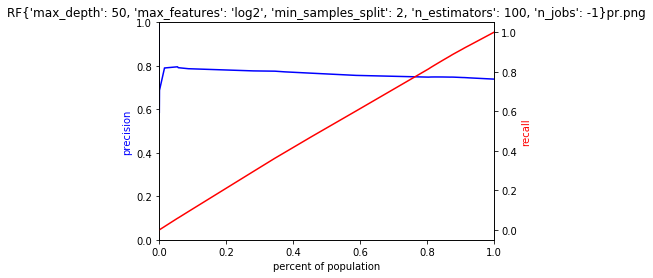

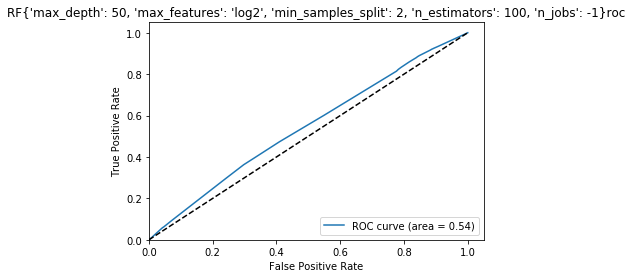

RF{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

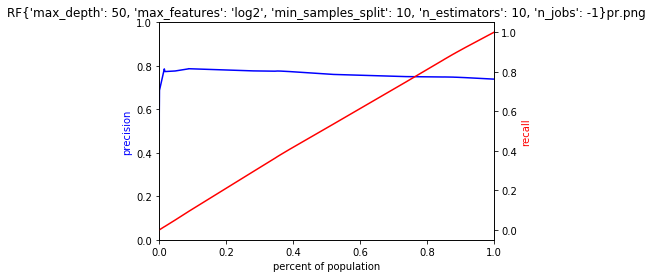

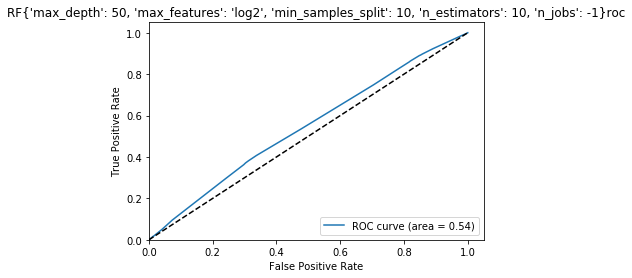

RF{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

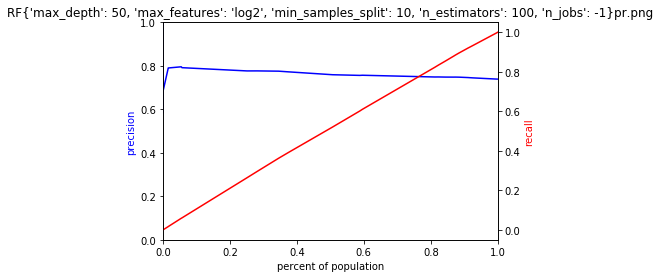

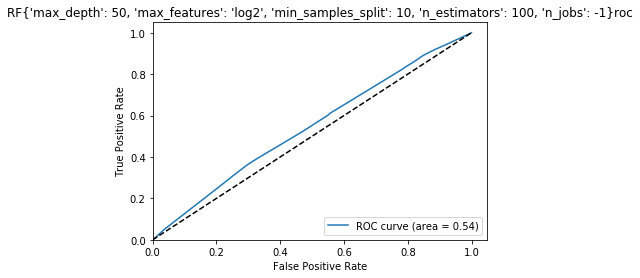

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

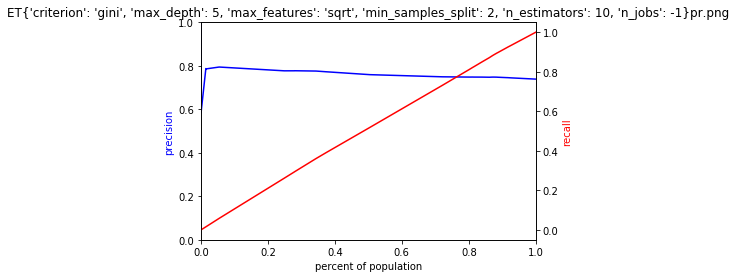

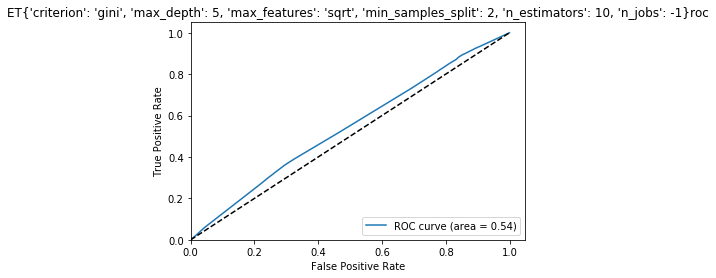

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

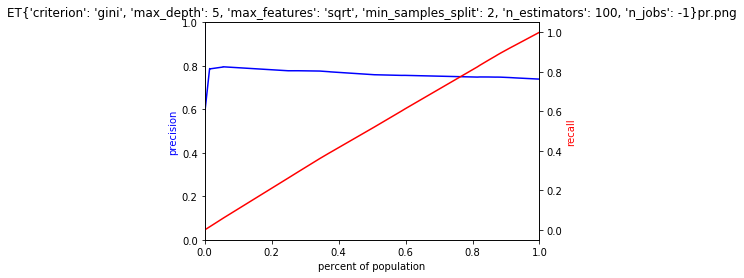

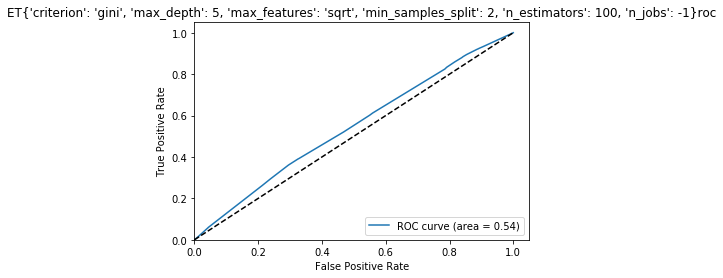

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

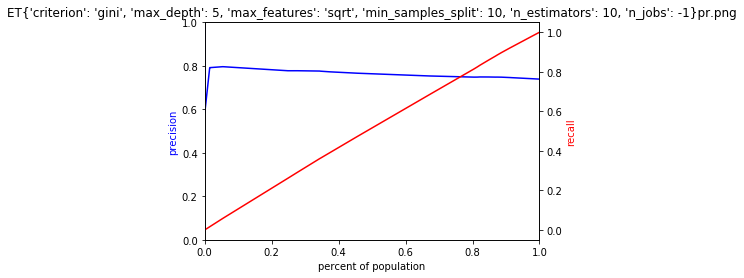

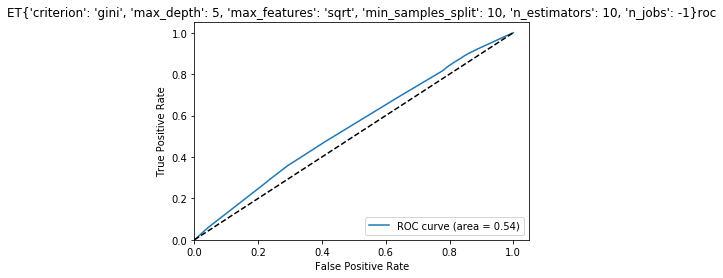

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

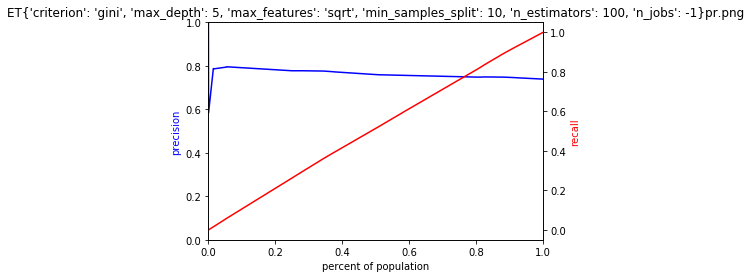

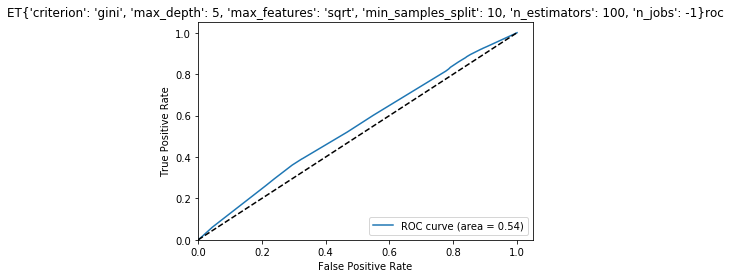

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

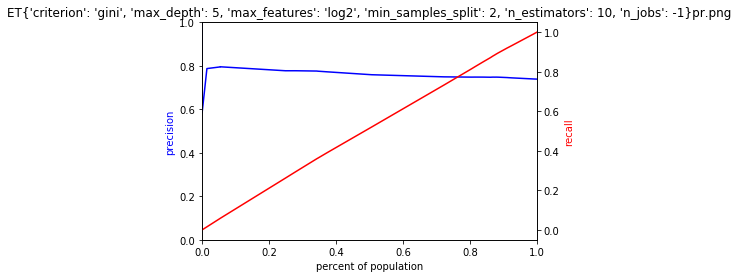

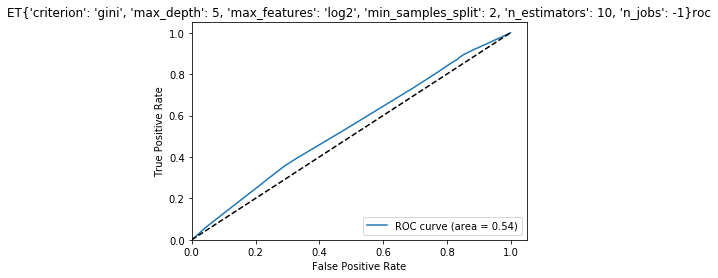

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

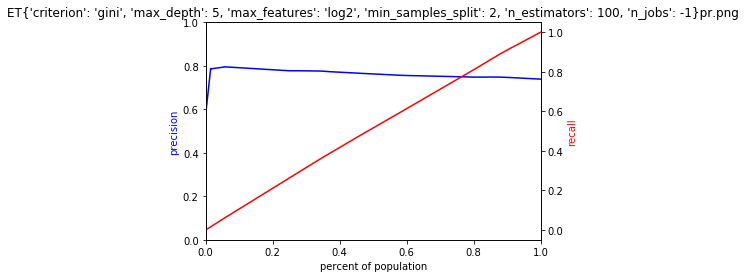

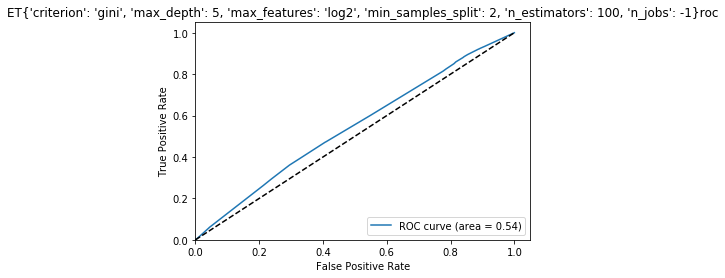

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

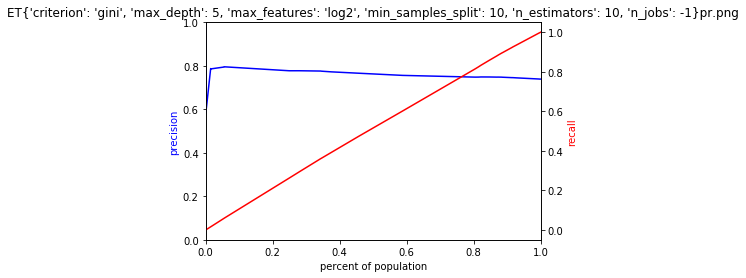

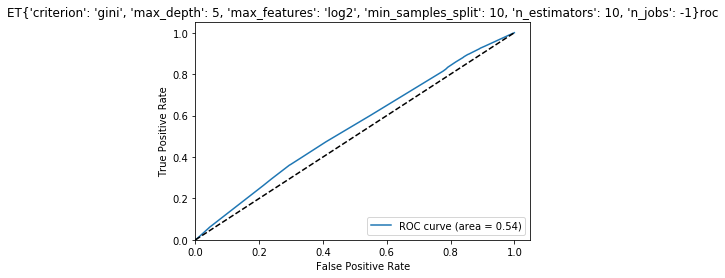

ET{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

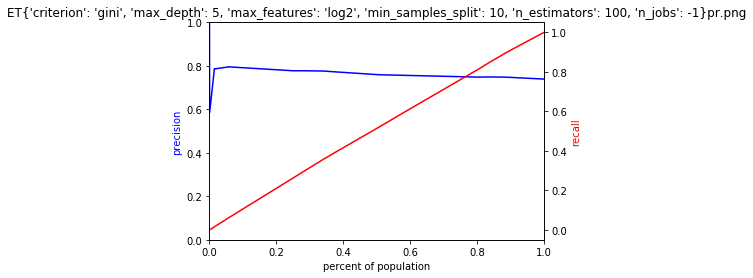

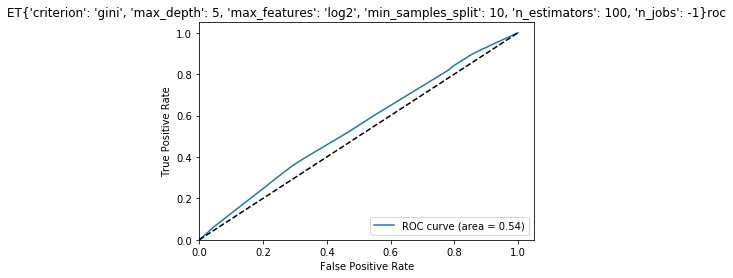

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

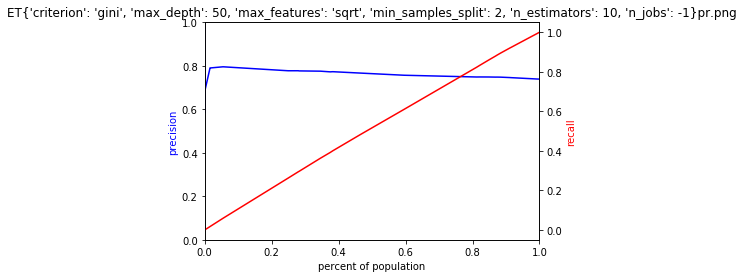

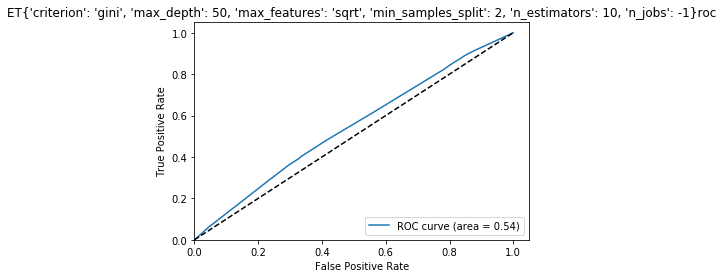

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

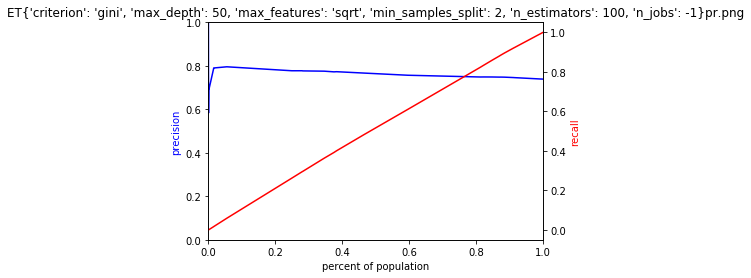

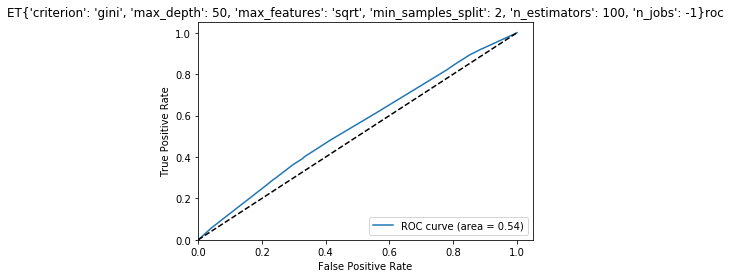

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

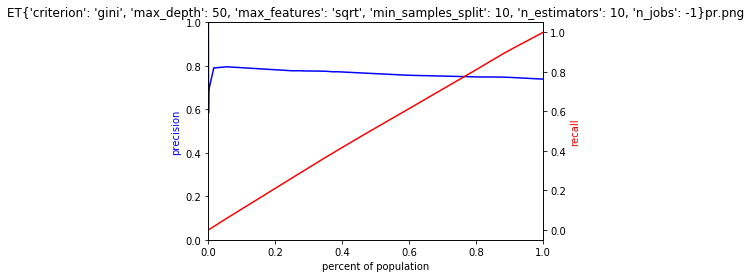

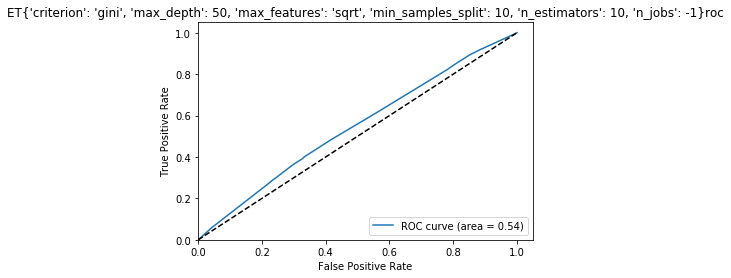

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

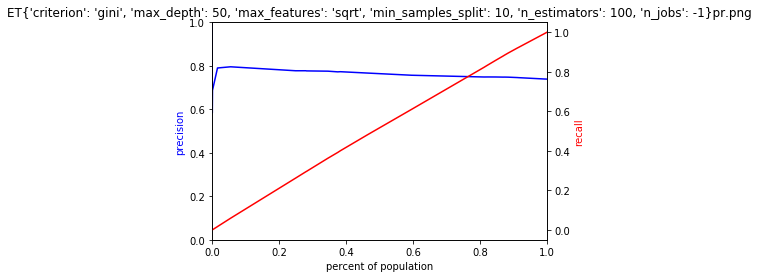

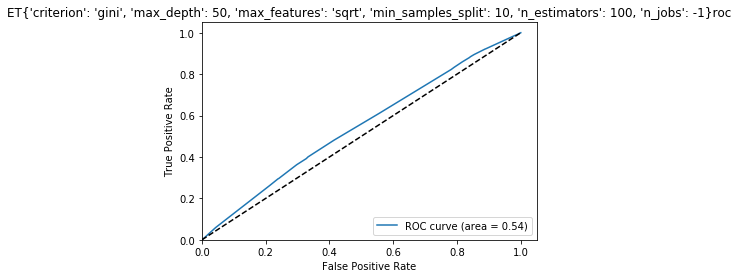

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

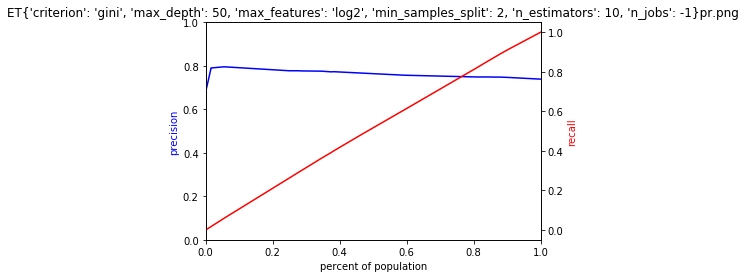

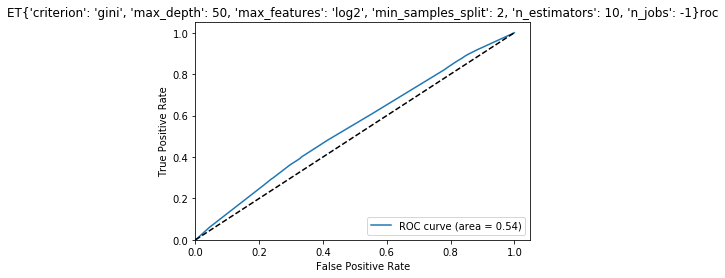

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

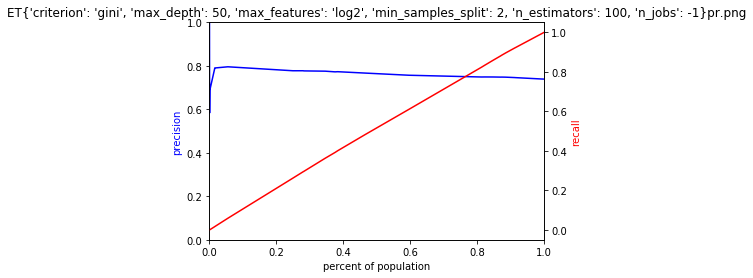

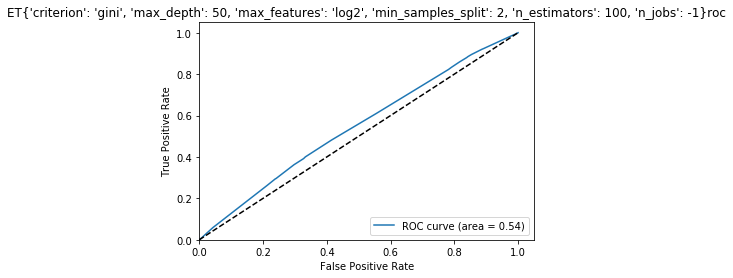

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

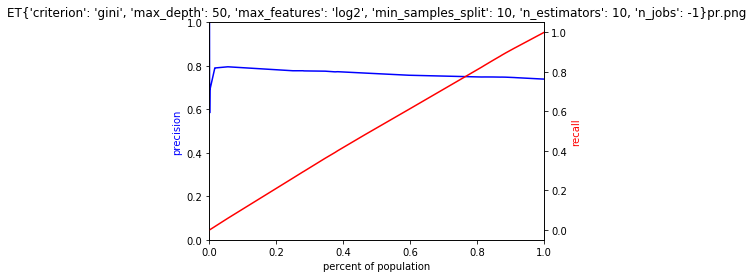

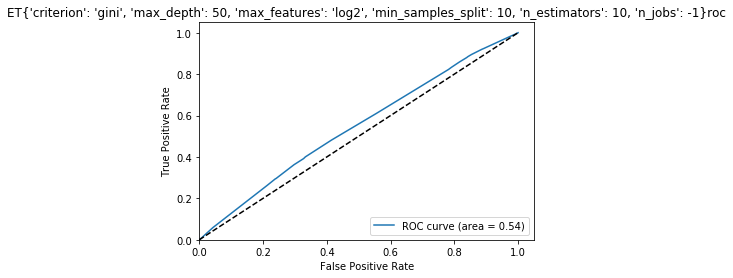

ET{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

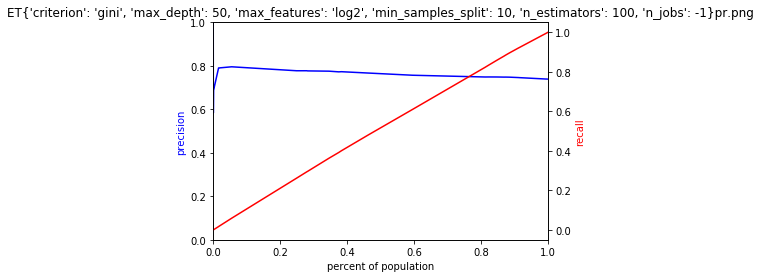

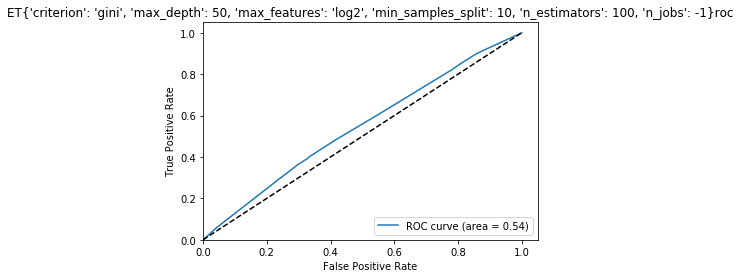

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

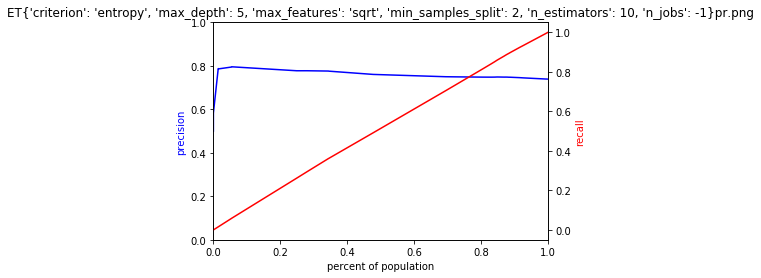

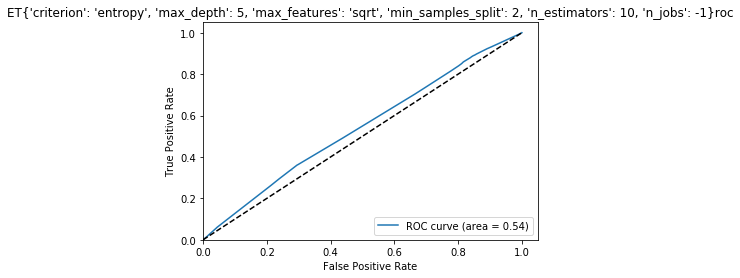

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

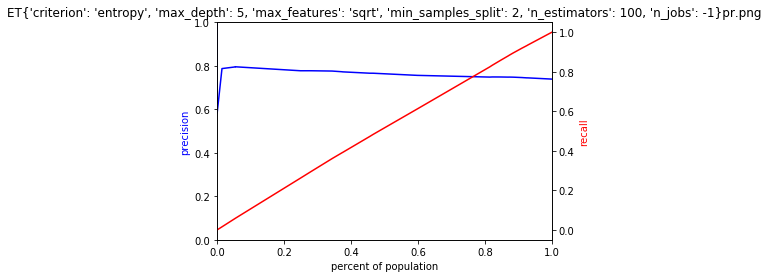

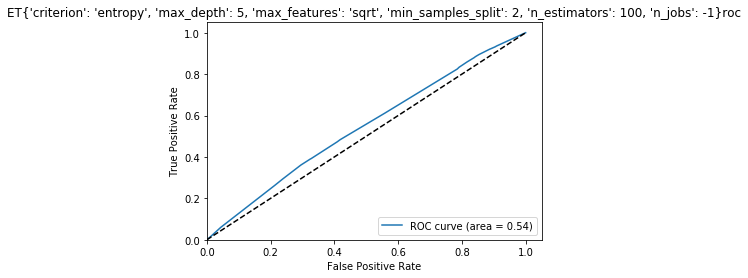

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

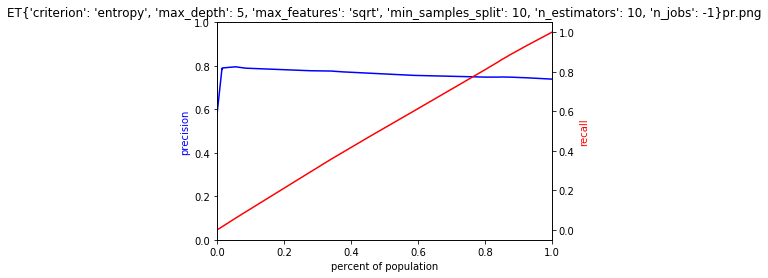

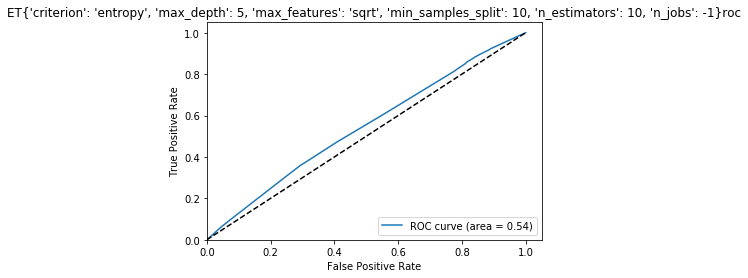

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

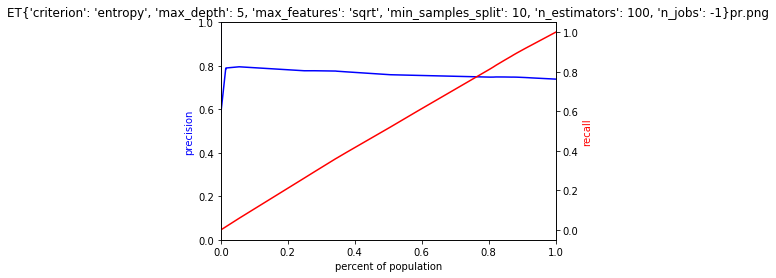

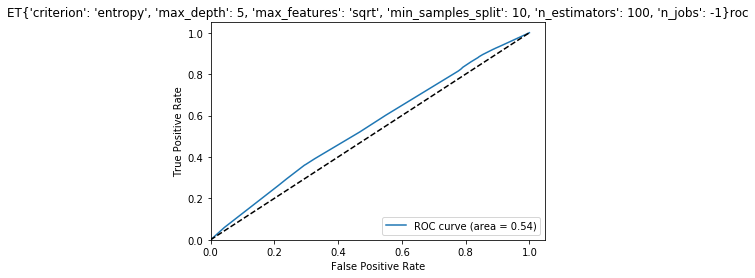

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

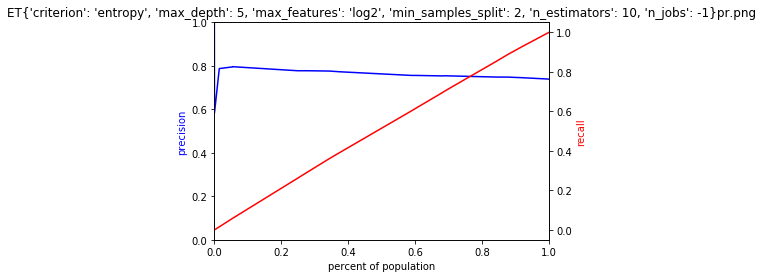

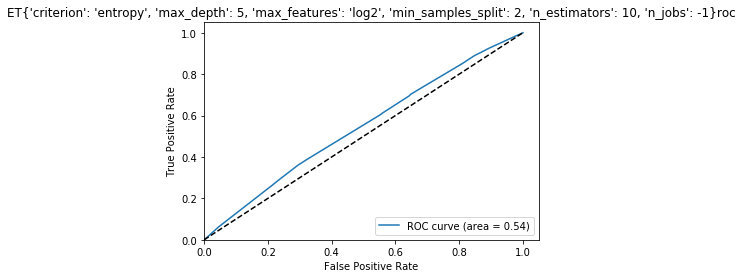

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

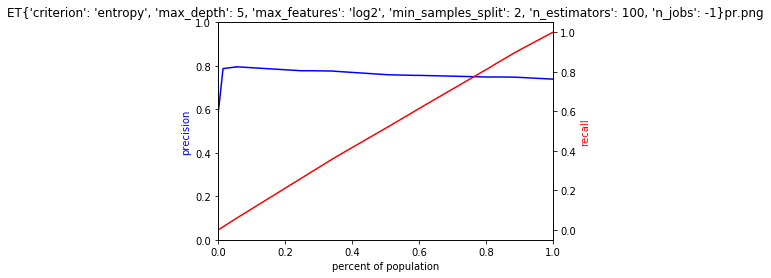

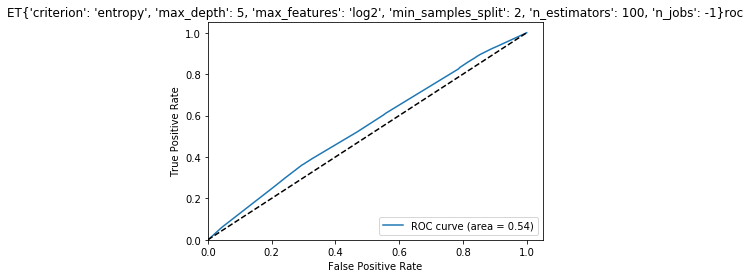

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

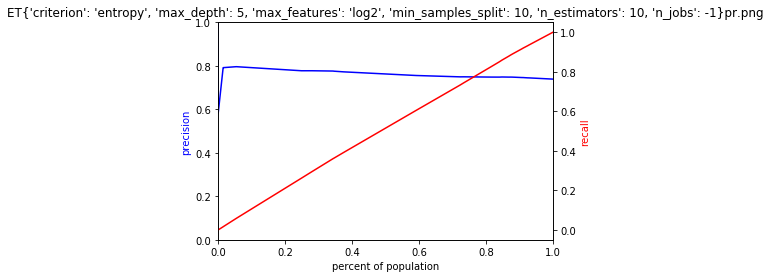

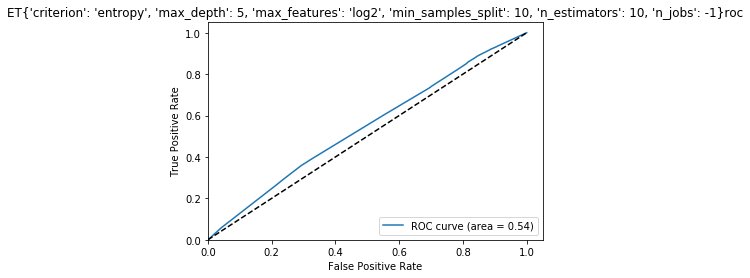

ET{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

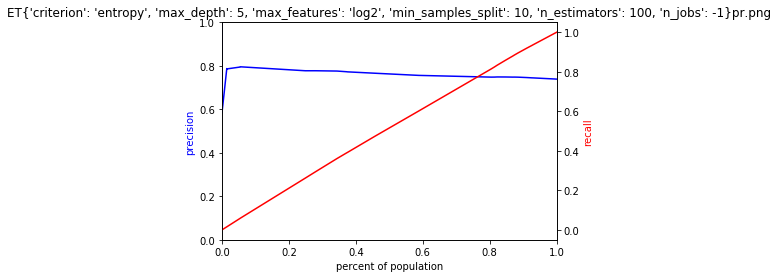

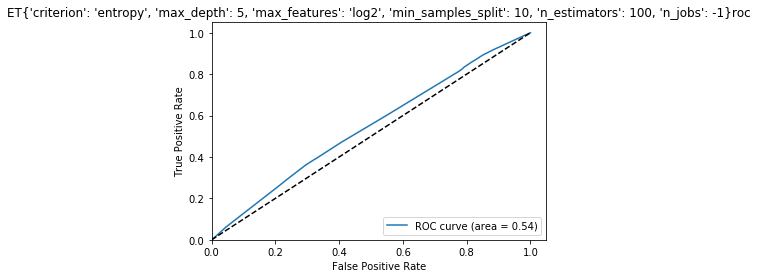

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

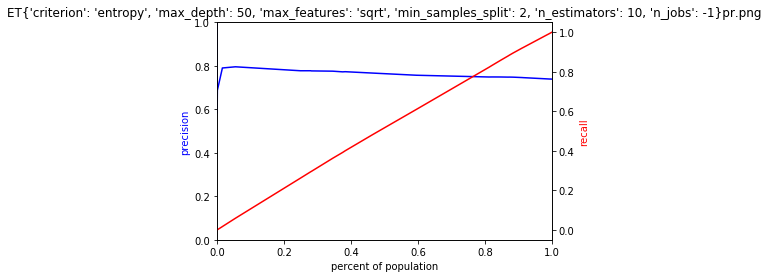

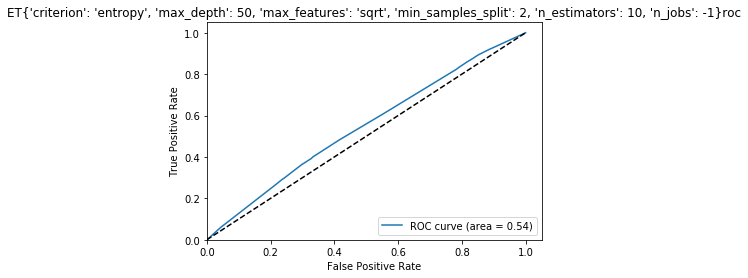

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

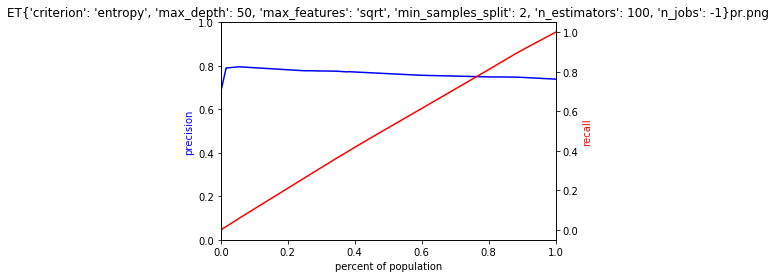

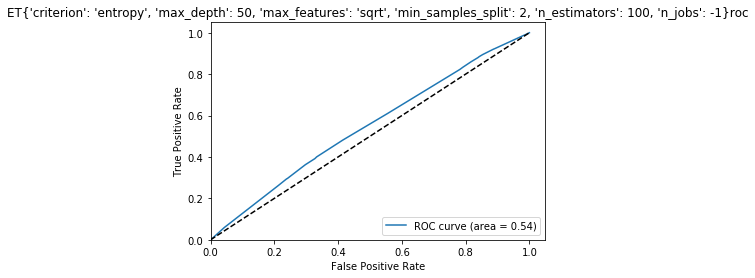

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

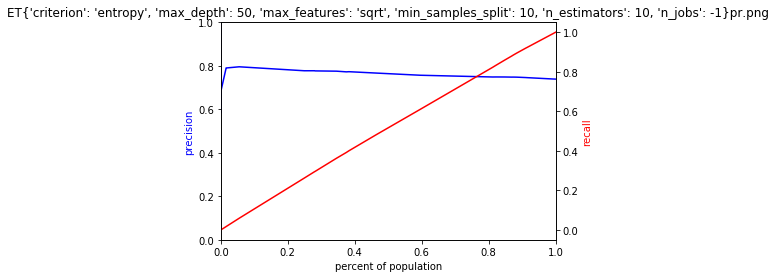

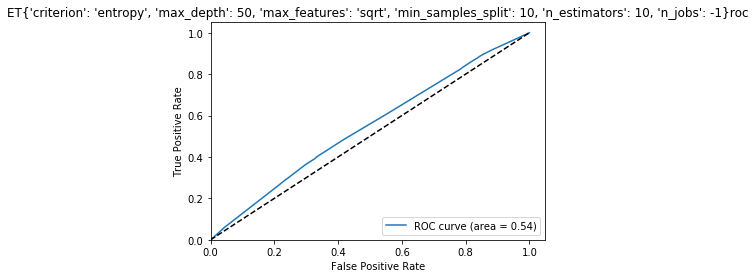

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

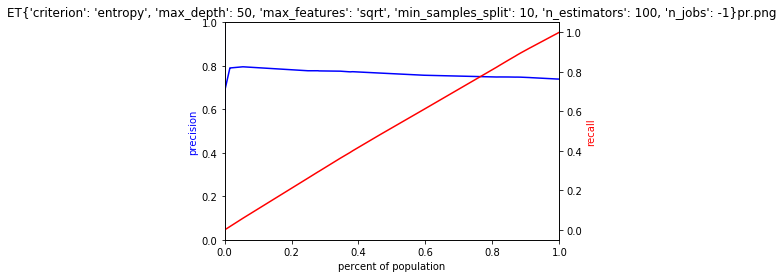

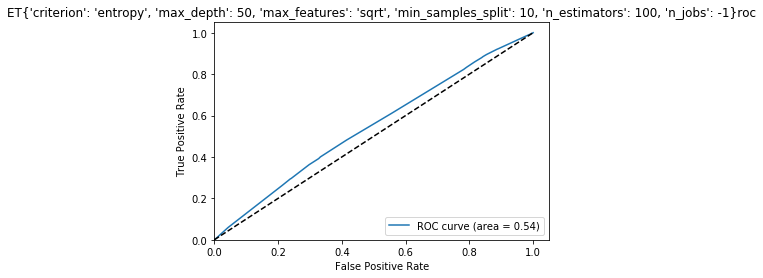

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

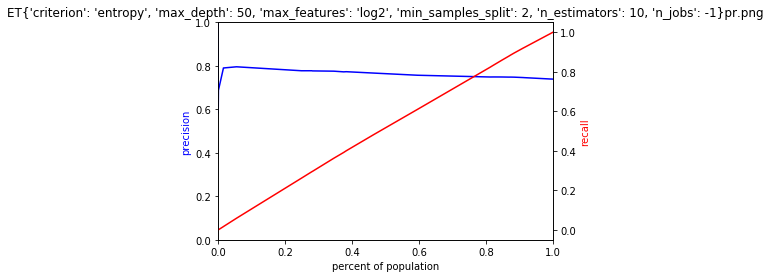

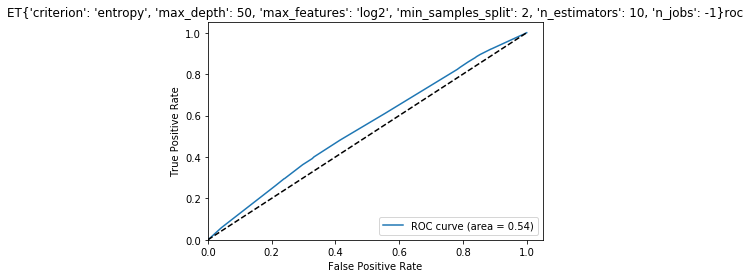

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

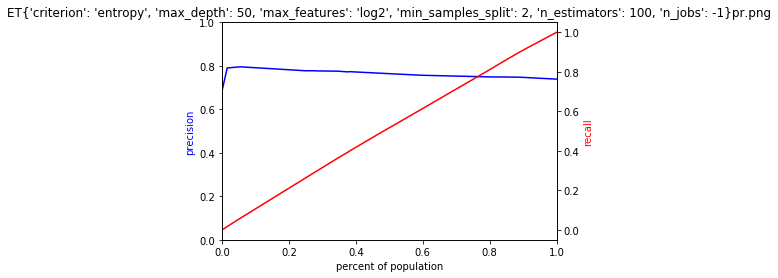

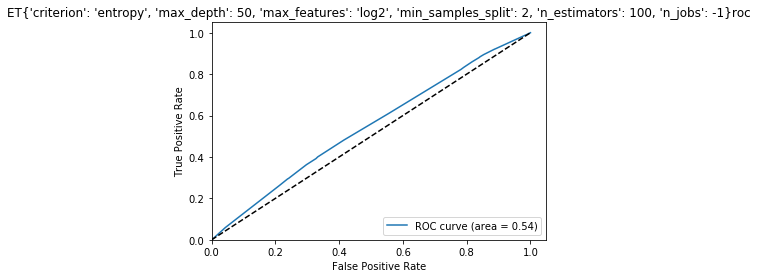

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

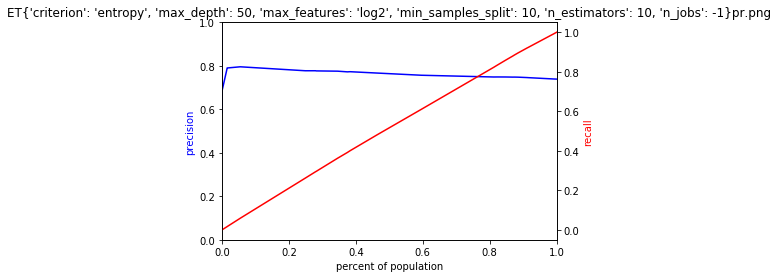

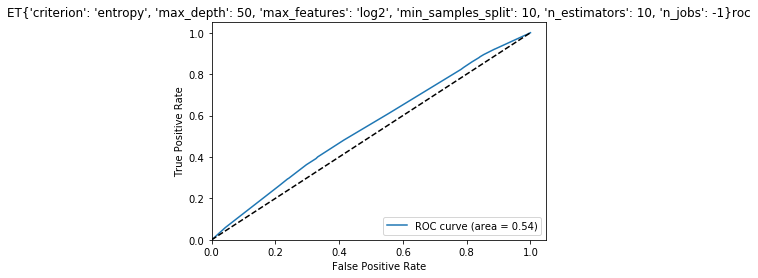

ET{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


<Figure size 432x288 with 0 Axes>

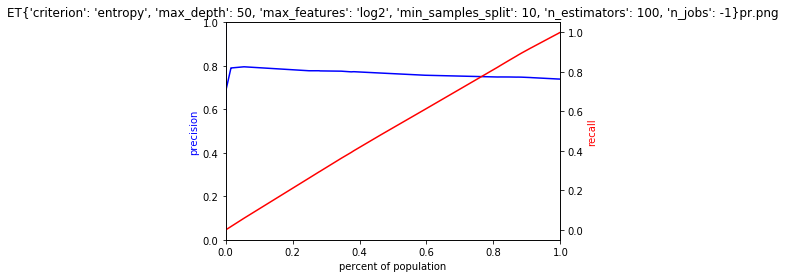

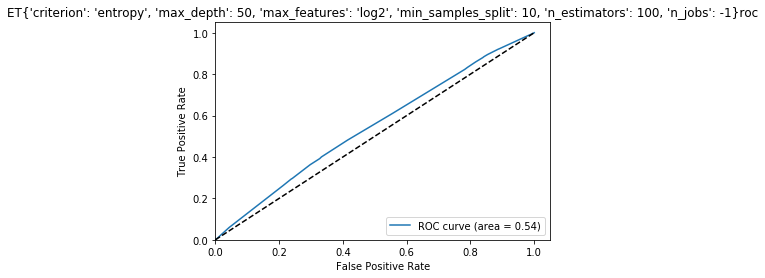

AB{'algorithm': 'SAMME', 'n_estimators': 1}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

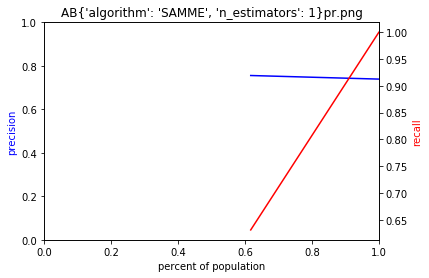

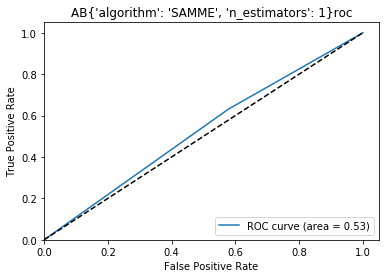

AB{'algorithm': 'SAMME', 'n_estimators': 10}


<Figure size 432x288 with 0 Axes>

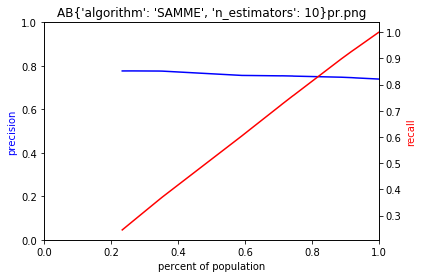

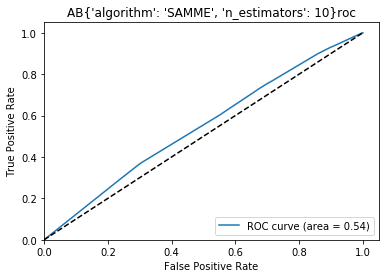

AB{'algorithm': 'SAMME', 'n_estimators': 100}


<Figure size 432x288 with 0 Axes>

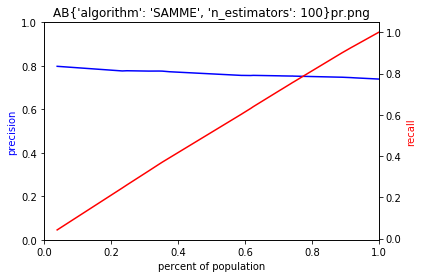

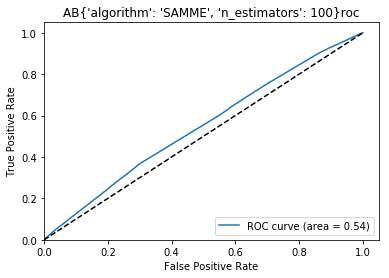

AB{'algorithm': 'SAMME', 'n_estimators': 1000}


<Figure size 432x288 with 0 Axes>

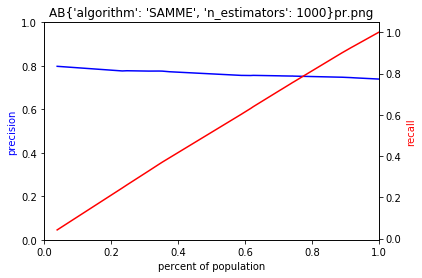

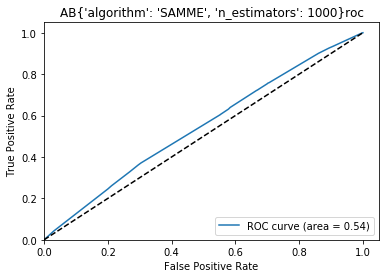

AB{'algorithm': 'SAMME', 'n_estimators': 10000}


<Figure size 432x288 with 0 Axes>

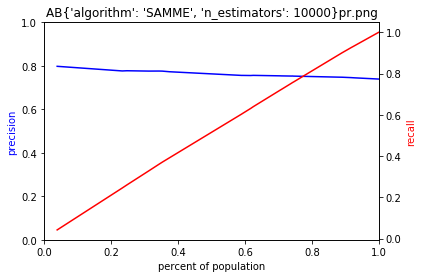

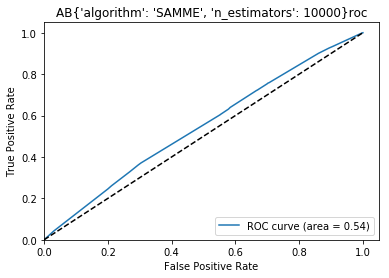

AB{'algorithm': 'SAMME.R', 'n_estimators': 1}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

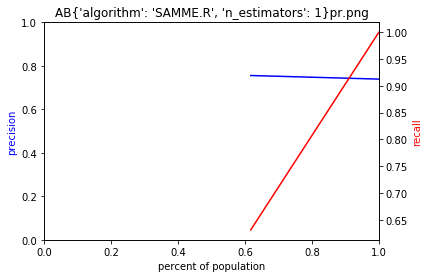

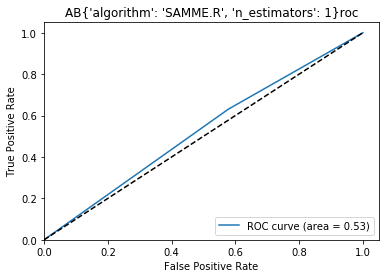

AB{'algorithm': 'SAMME.R', 'n_estimators': 10}


<Figure size 432x288 with 0 Axes>

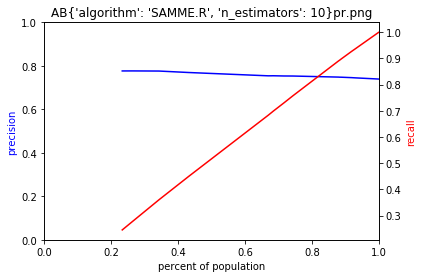

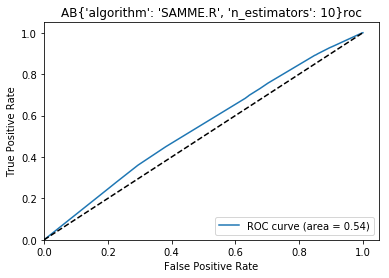

AB{'algorithm': 'SAMME.R', 'n_estimators': 100}


<Figure size 432x288 with 0 Axes>

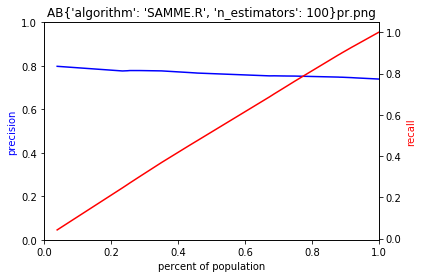

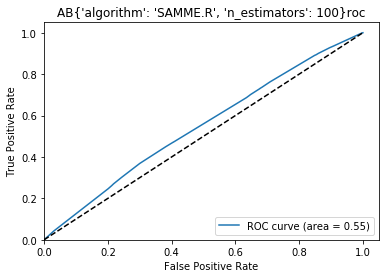

AB{'algorithm': 'SAMME.R', 'n_estimators': 1000}


<Figure size 432x288 with 0 Axes>

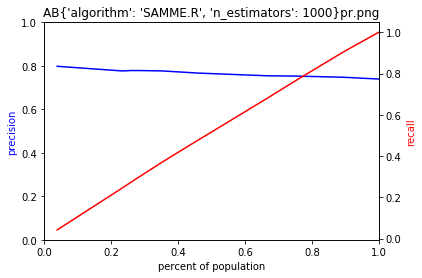

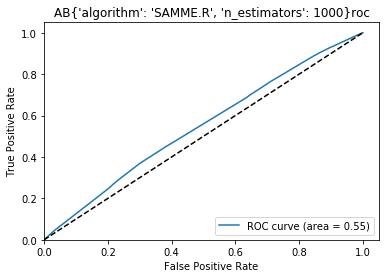

AB{'algorithm': 'SAMME.R', 'n_estimators': 10000}


<Figure size 432x288 with 0 Axes>

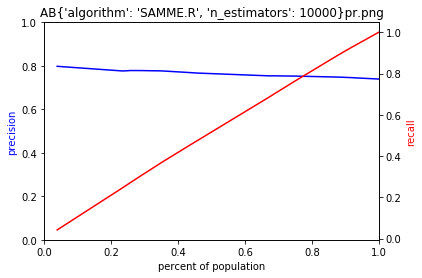

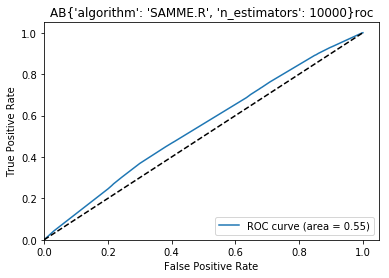

LR{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

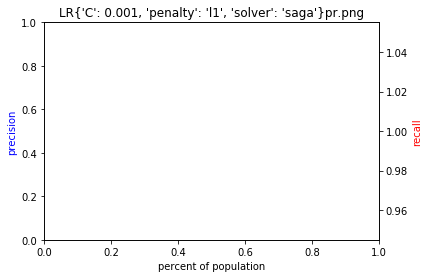

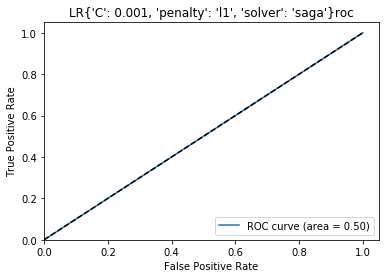

LR{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

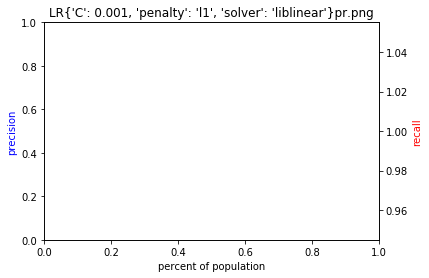

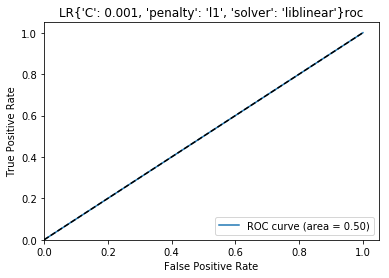

LR{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


<Figure size 432x288 with 0 Axes>

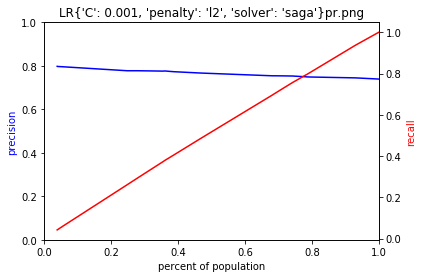

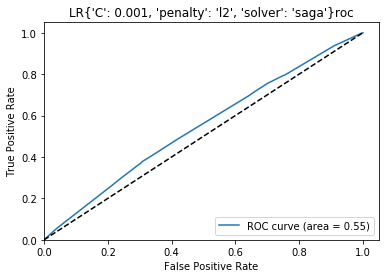

LR{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


<Figure size 432x288 with 0 Axes>

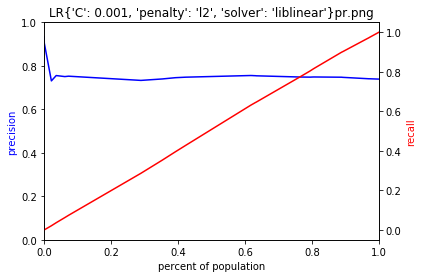

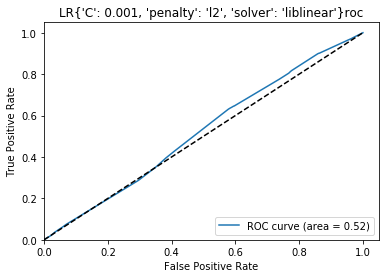

LR{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


<Figure size 432x288 with 0 Axes>

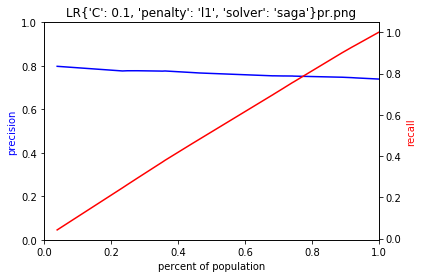

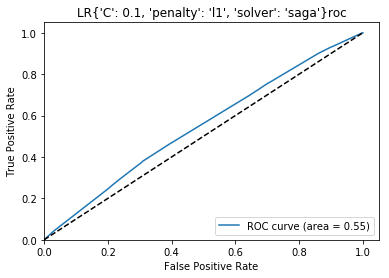

LR{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


<Figure size 432x288 with 0 Axes>

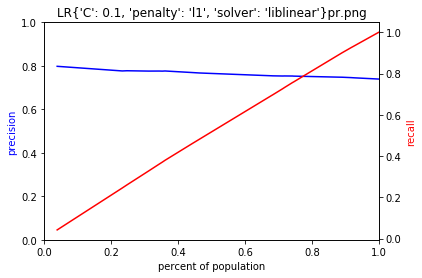

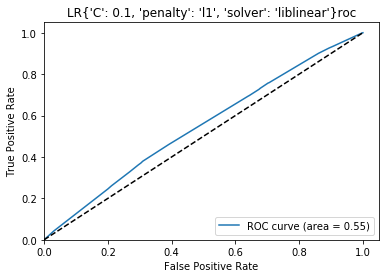

LR{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


<Figure size 432x288 with 0 Axes>

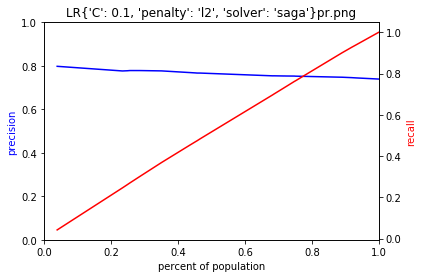

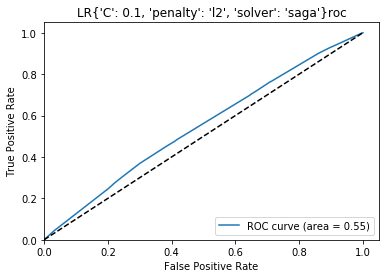

LR{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


<Figure size 432x288 with 0 Axes>

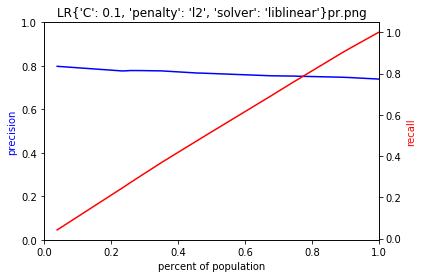

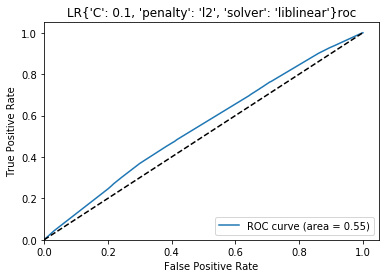

LR{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


<Figure size 432x288 with 0 Axes>

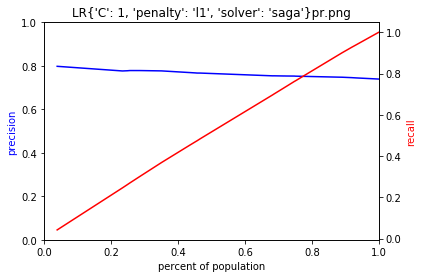

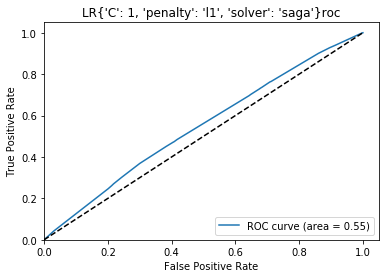

LR{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


<Figure size 432x288 with 0 Axes>

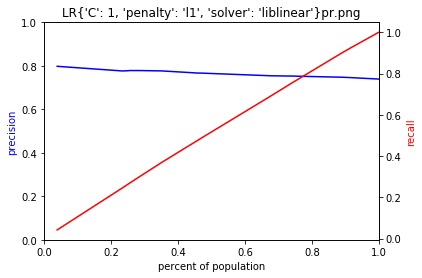

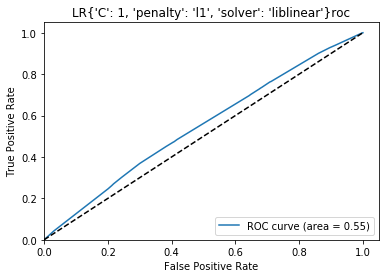

LR{'C': 1, 'penalty': 'l2', 'solver': 'saga'}


<Figure size 432x288 with 0 Axes>

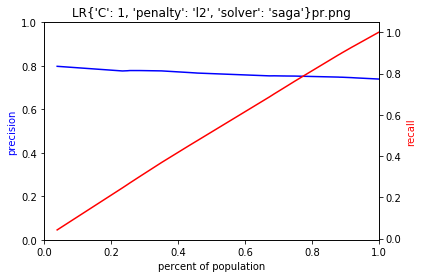

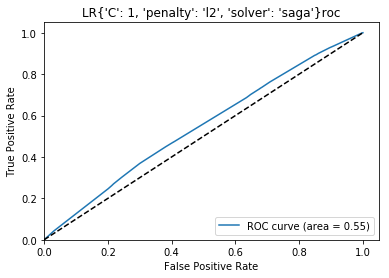

LR{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


<Figure size 432x288 with 0 Axes>

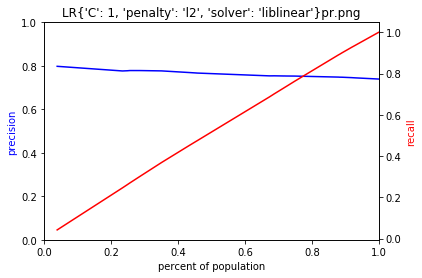

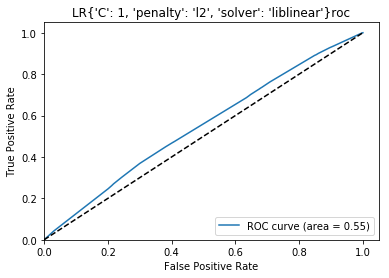

SVM{'C': 0.1, 'kernel': 'linear'}


<Figure size 432x288 with 0 Axes>

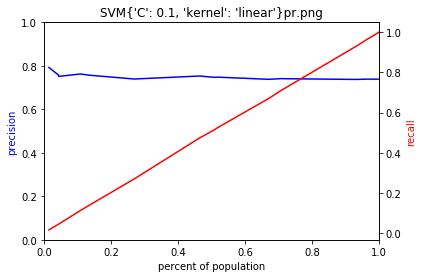

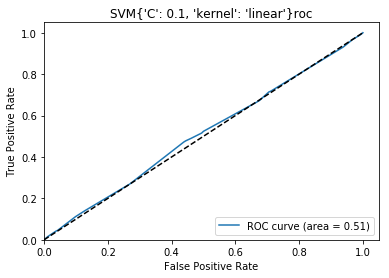

GB{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

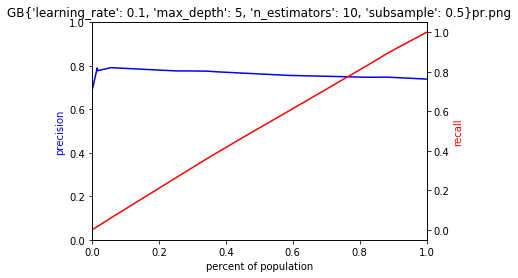

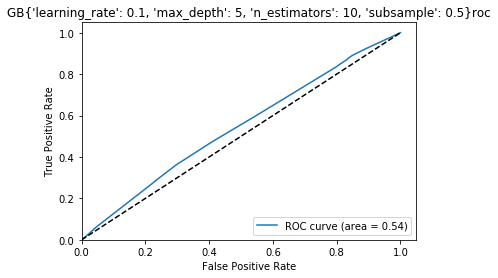

GB{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

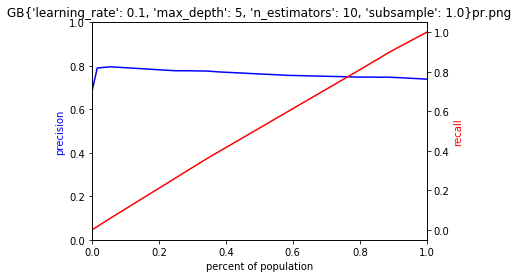

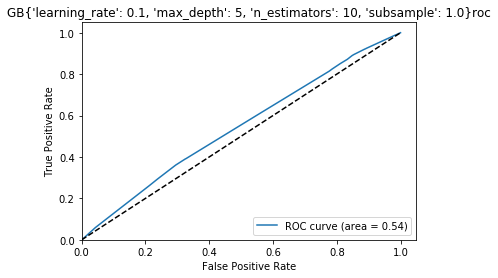

GB{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

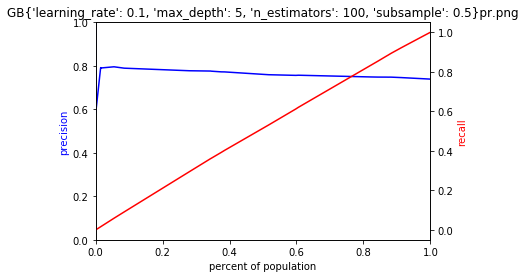

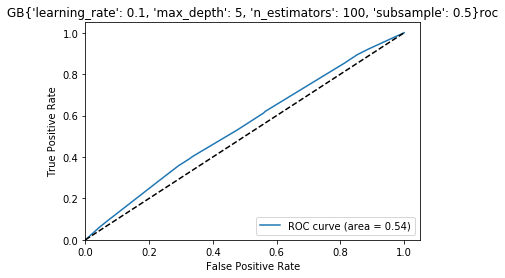

GB{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

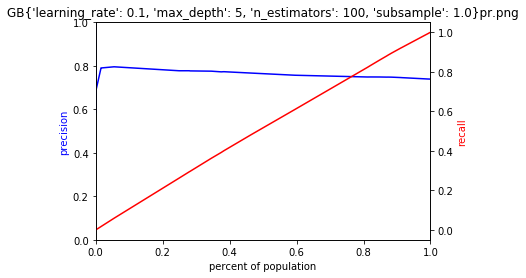

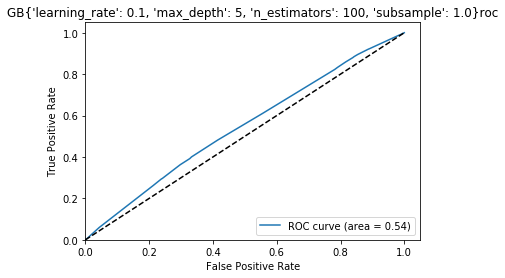

GB{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

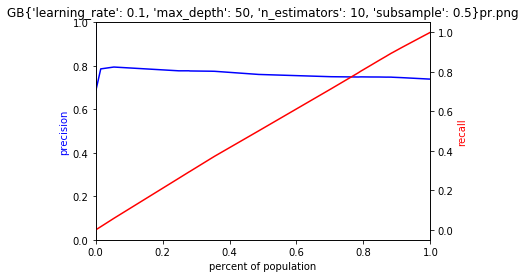

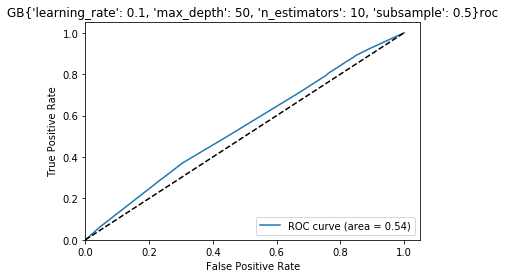

GB{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

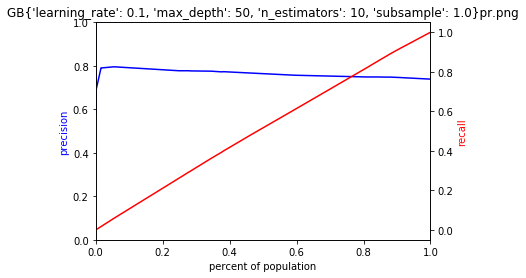

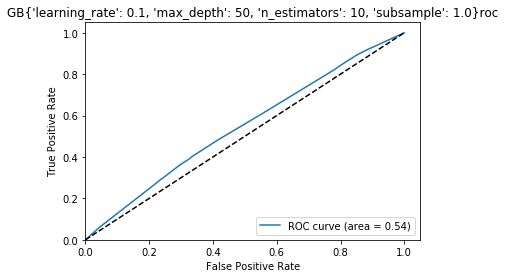

GB{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

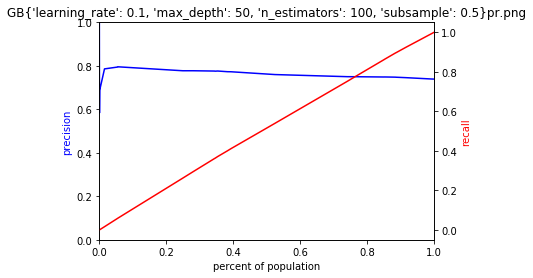

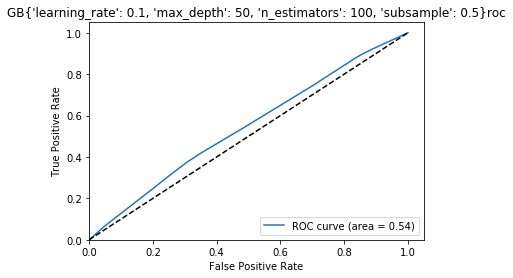

GB{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

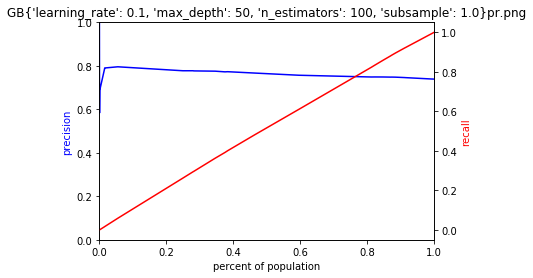

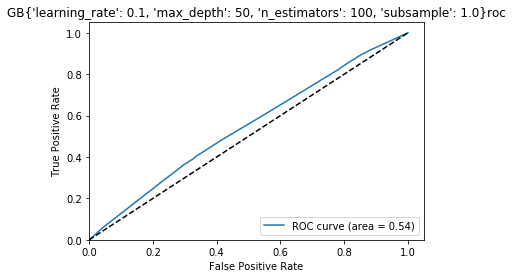

GB{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

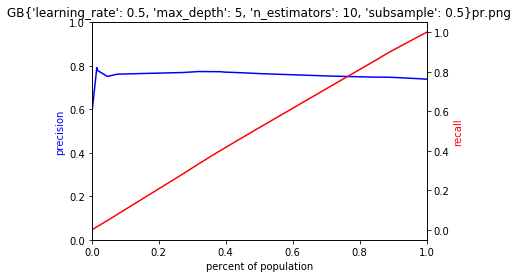

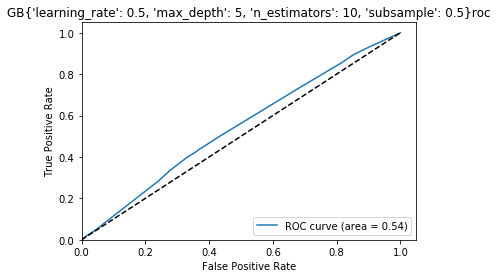

GB{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

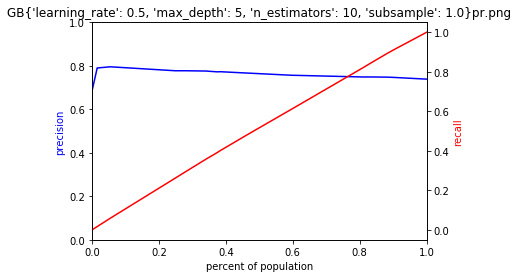

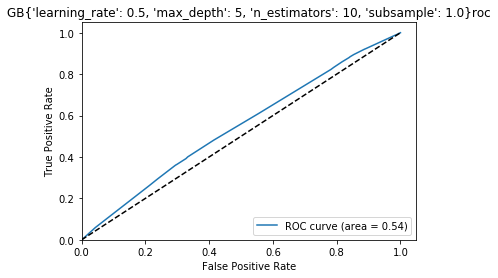

GB{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

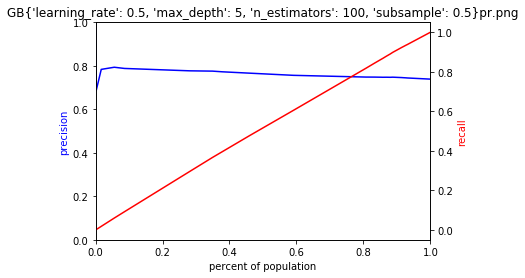

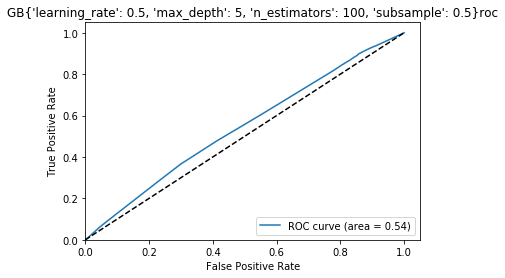

GB{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

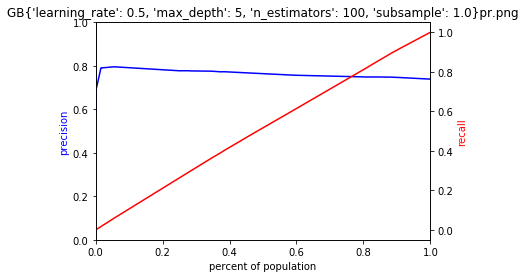

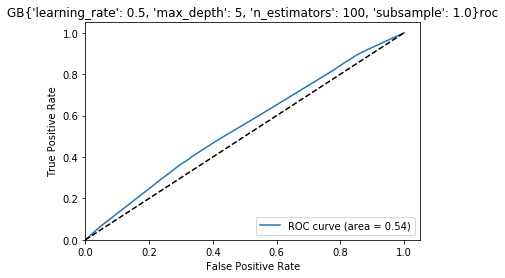

GB{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

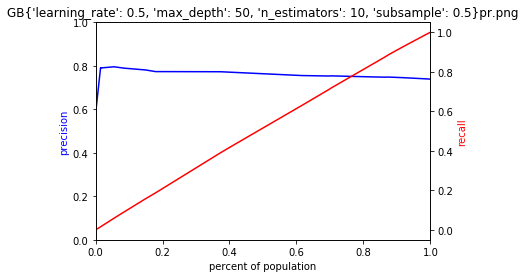

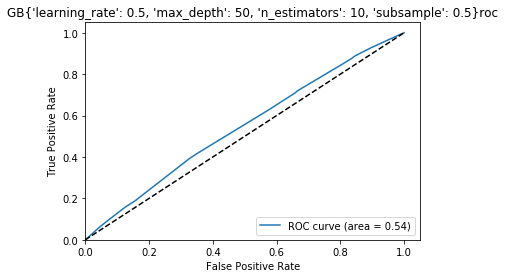

GB{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

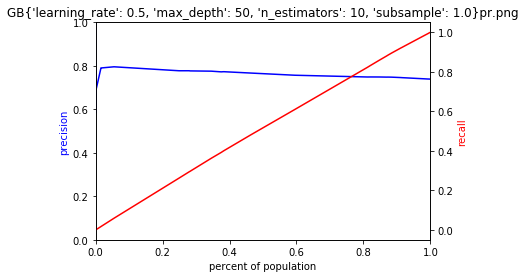

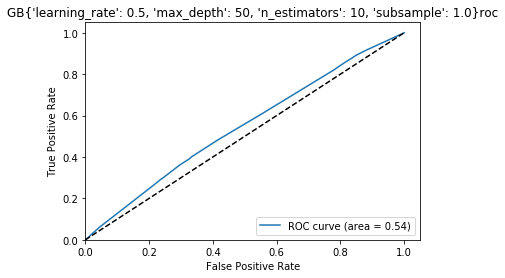

GB{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.5}


<Figure size 432x288 with 0 Axes>

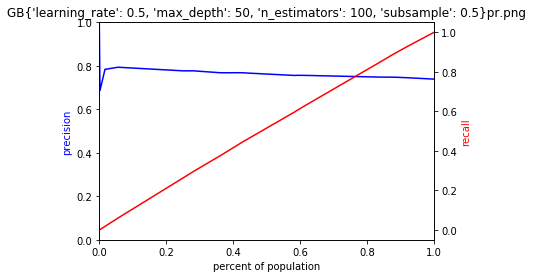

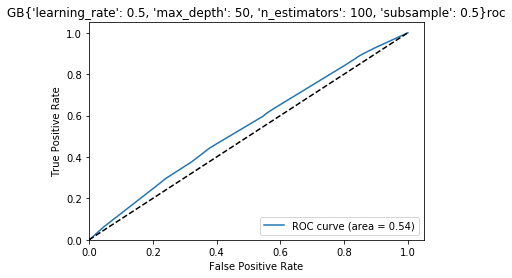

GB{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 100, 'subsample': 1.0}


<Figure size 432x288 with 0 Axes>

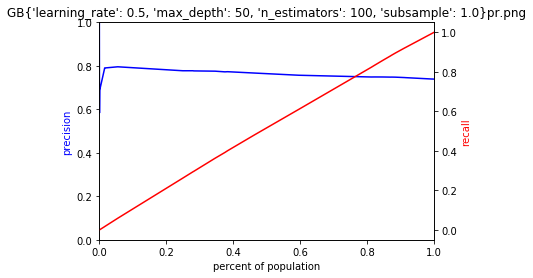

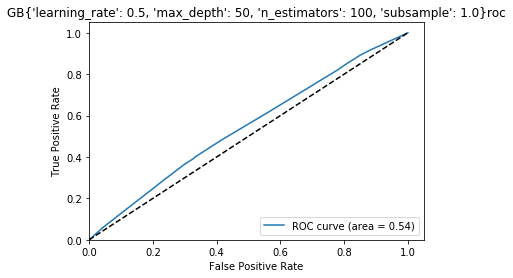

NB{}


<Figure size 432x288 with 0 Axes>

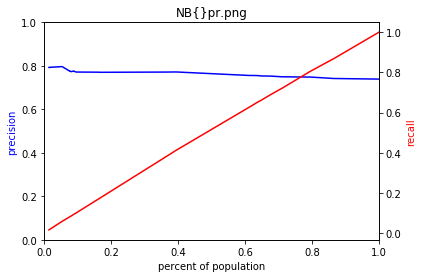

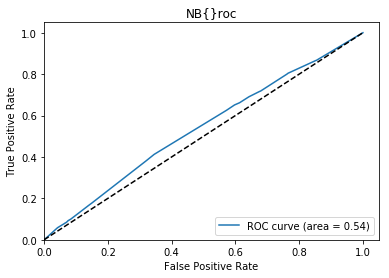

DT{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

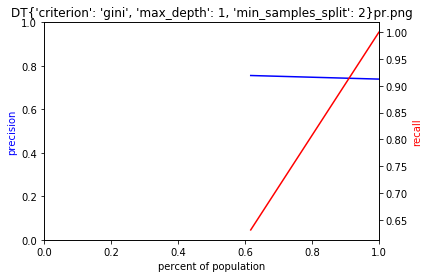

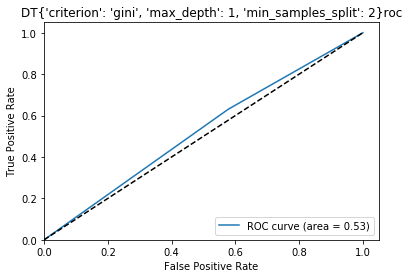

DT{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

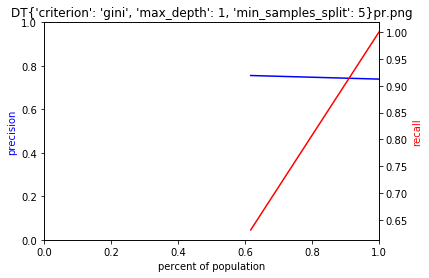

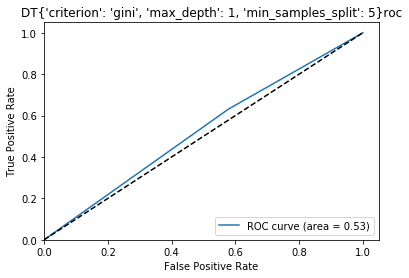

DT{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

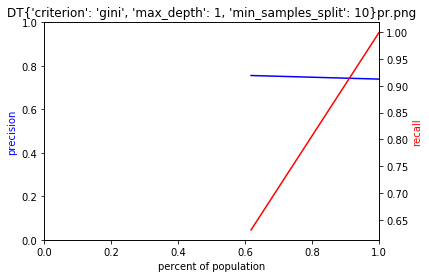

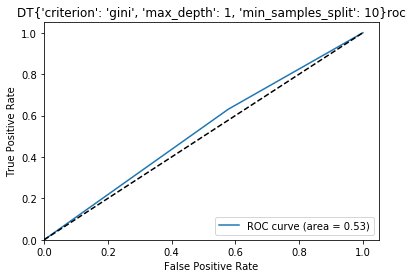

DT{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


<Figure size 432x288 with 0 Axes>

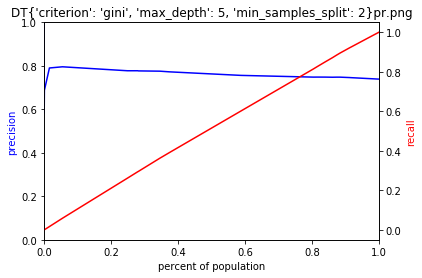

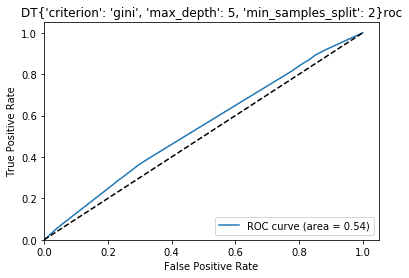

DT{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}


<Figure size 432x288 with 0 Axes>

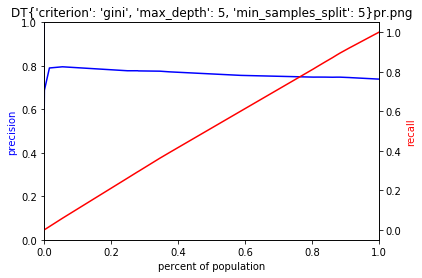

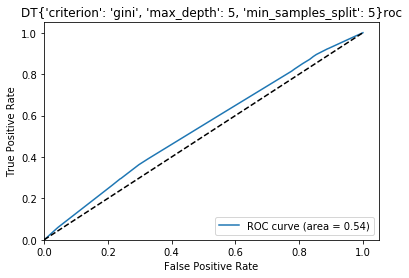

DT{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}


<Figure size 432x288 with 0 Axes>

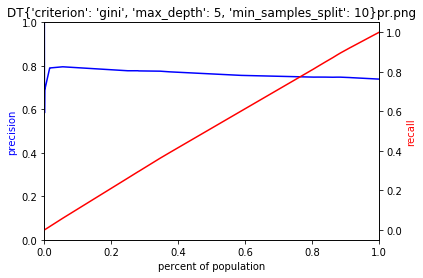

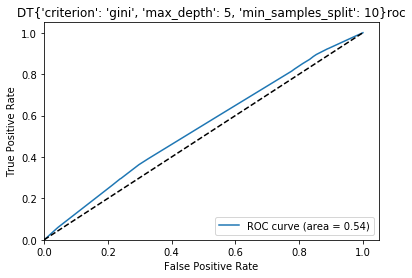

DT{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}


<Figure size 432x288 with 0 Axes>

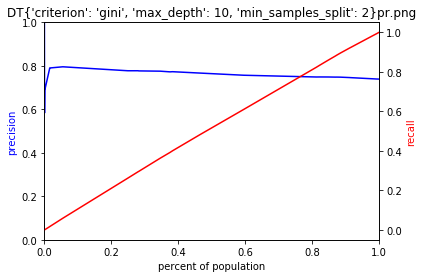

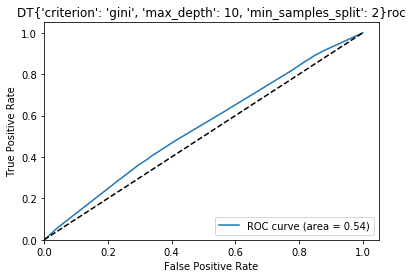

DT{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


<Figure size 432x288 with 0 Axes>

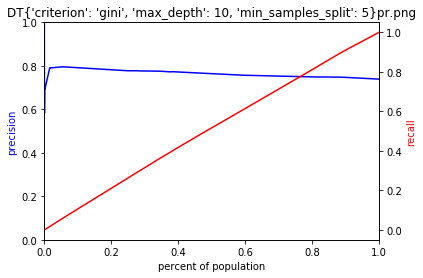

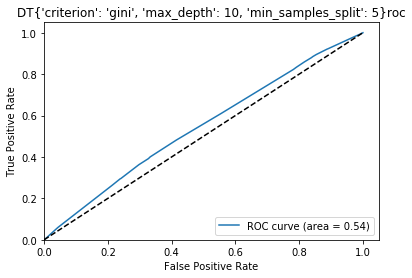

DT{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}


<Figure size 432x288 with 0 Axes>

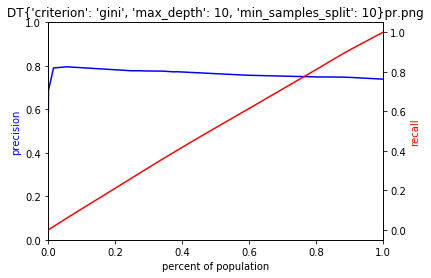

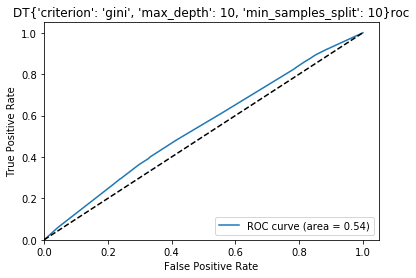

DT{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}


<Figure size 432x288 with 0 Axes>

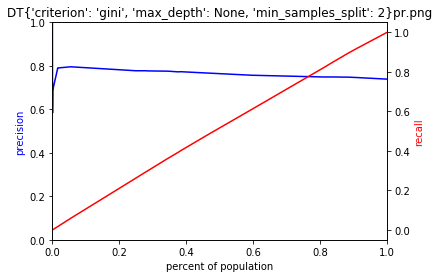

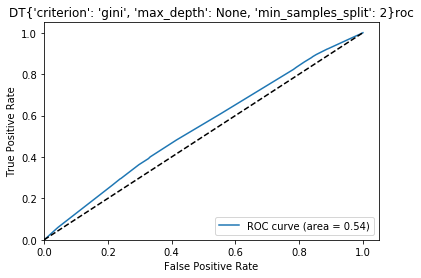

DT{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}


<Figure size 432x288 with 0 Axes>

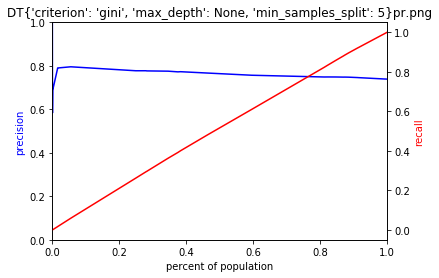

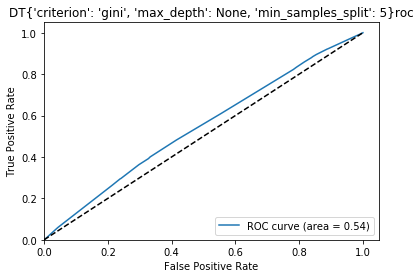

DT{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}


<Figure size 432x288 with 0 Axes>

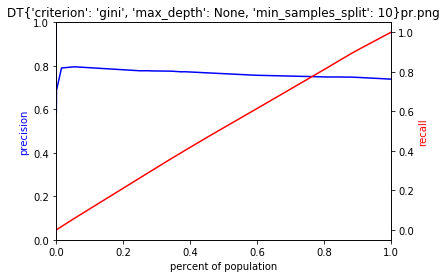

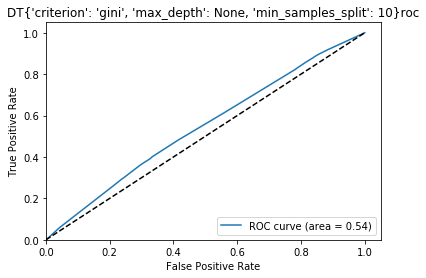

DT{'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

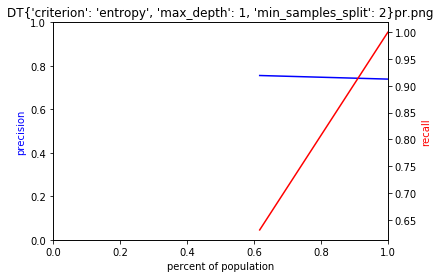

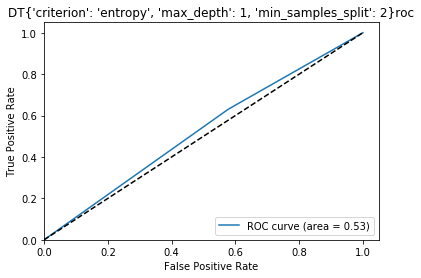

DT{'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

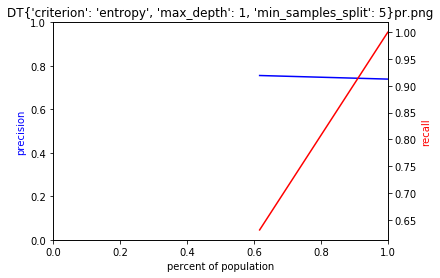

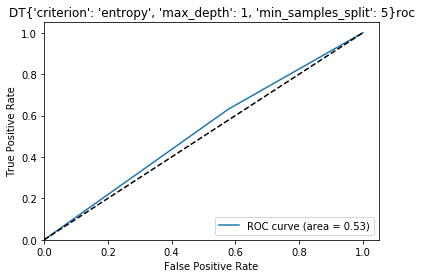

DT{'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

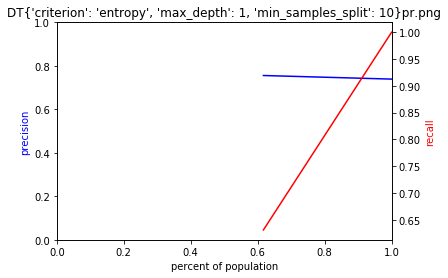

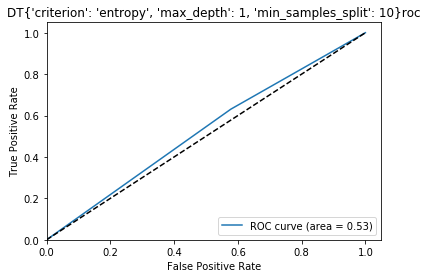

DT{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


<Figure size 432x288 with 0 Axes>

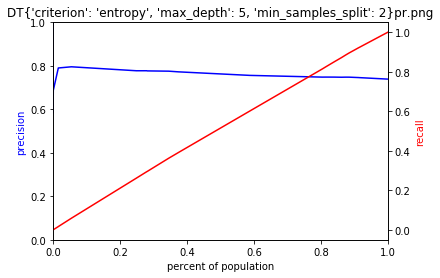

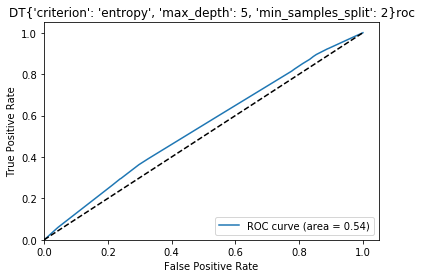

DT{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


<Figure size 432x288 with 0 Axes>

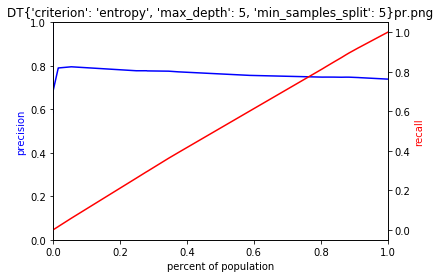

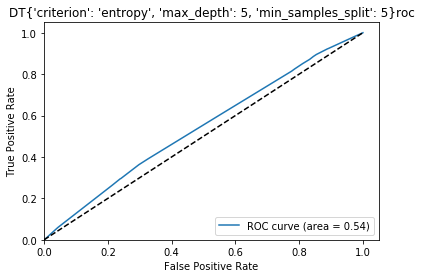

DT{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}


<Figure size 432x288 with 0 Axes>

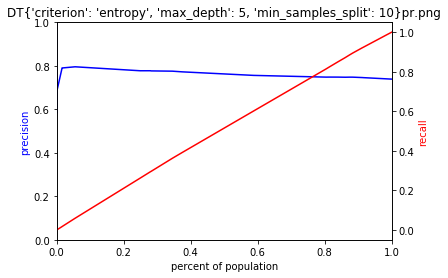

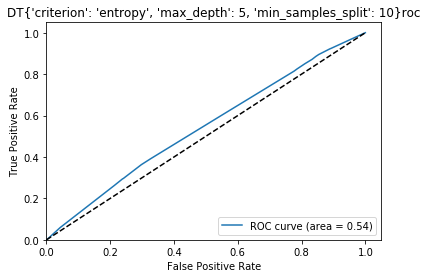

DT{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


<Figure size 432x288 with 0 Axes>

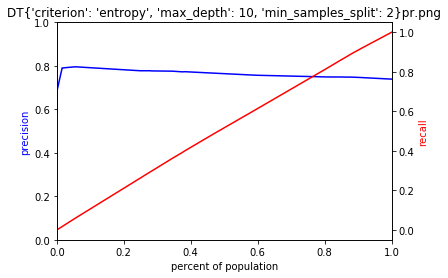

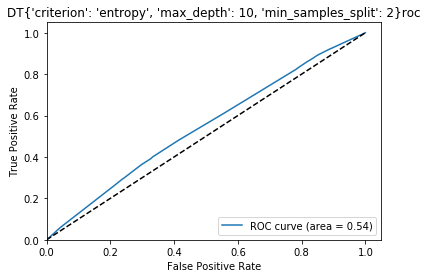

DT{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}


<Figure size 432x288 with 0 Axes>

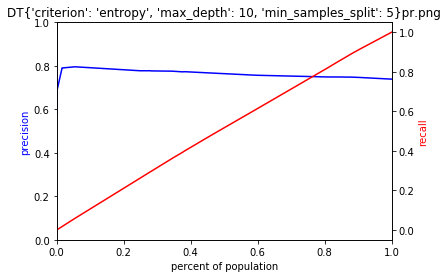

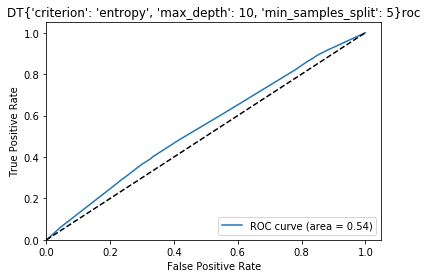

DT{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}


<Figure size 432x288 with 0 Axes>

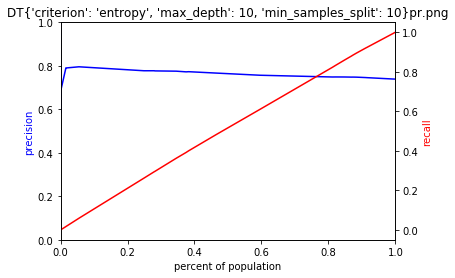

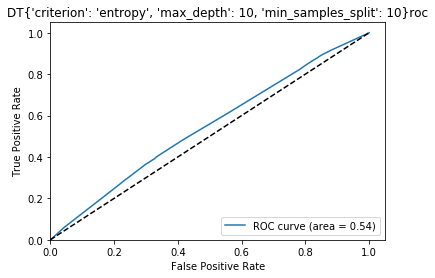

DT{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


<Figure size 432x288 with 0 Axes>

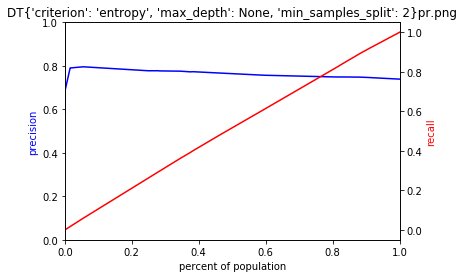

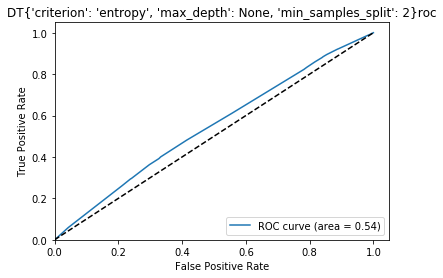

DT{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}


<Figure size 432x288 with 0 Axes>

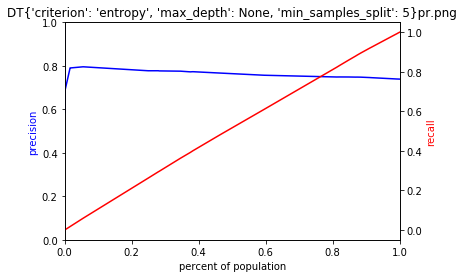

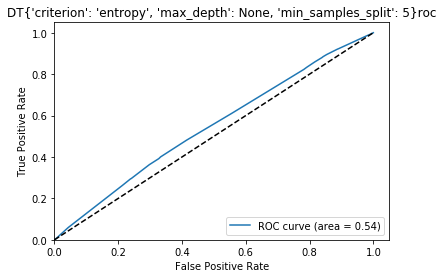

DT{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}


<Figure size 432x288 with 0 Axes>

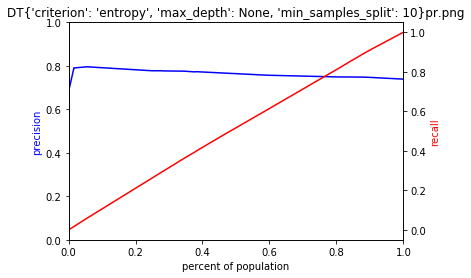

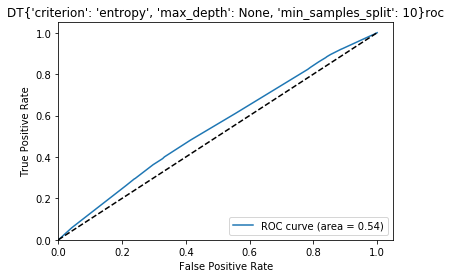

SGD{'loss': 'hinge', 'penalty': 'l2'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

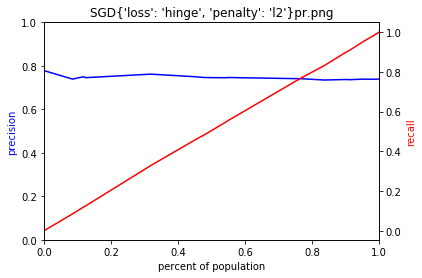

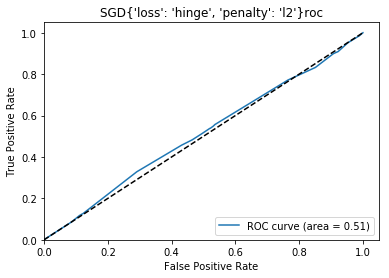

SGD{'loss': 'hinge', 'penalty': 'l1'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

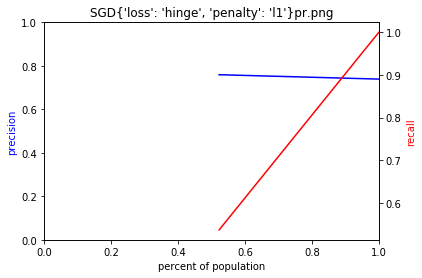

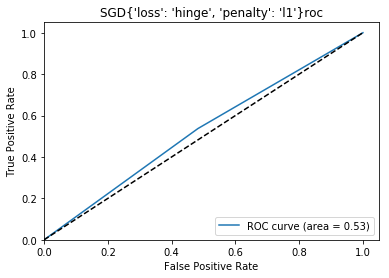

SGD{'loss': 'hinge', 'penalty': 'elasticnet'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

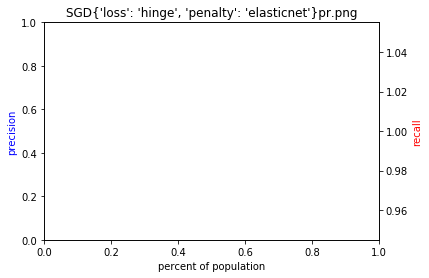

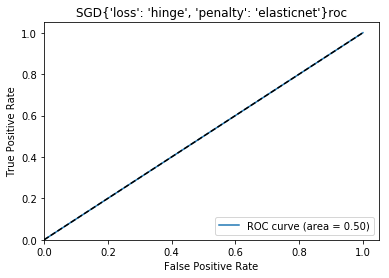

SGD{'loss': 'log', 'penalty': 'l2'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

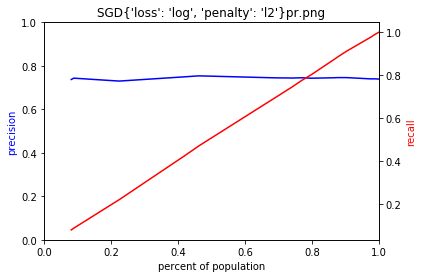

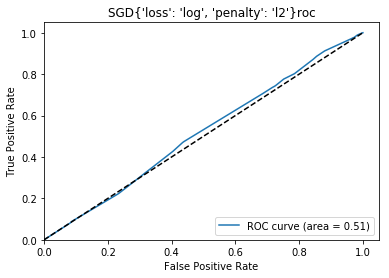

SGD{'loss': 'log', 'penalty': 'l1'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

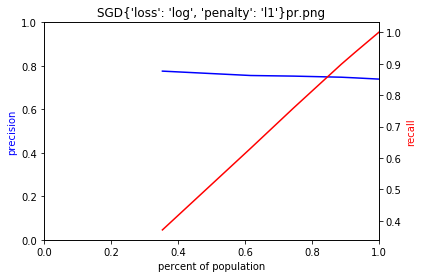

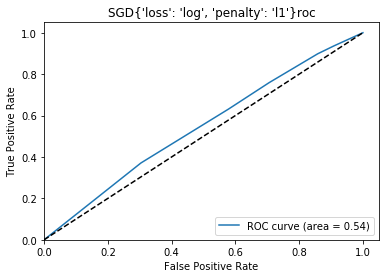

SGD{'loss': 'log', 'penalty': 'elasticnet'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

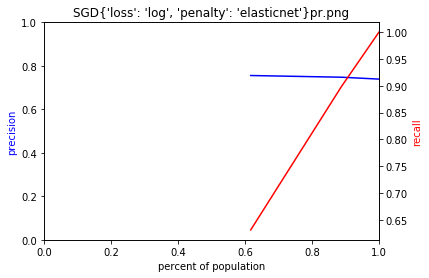

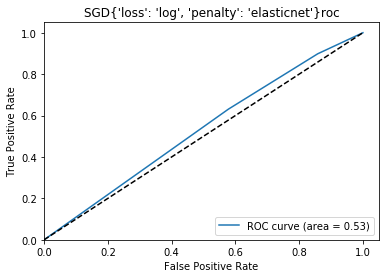

SGD{'loss': 'perceptron', 'penalty': 'l2'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

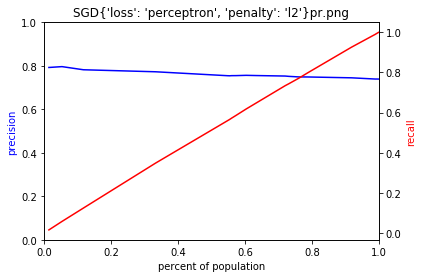

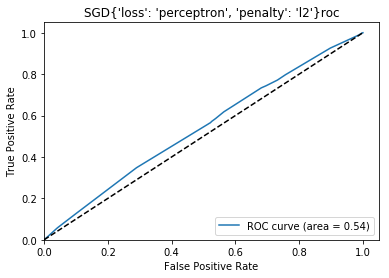

SGD{'loss': 'perceptron', 'penalty': 'l1'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

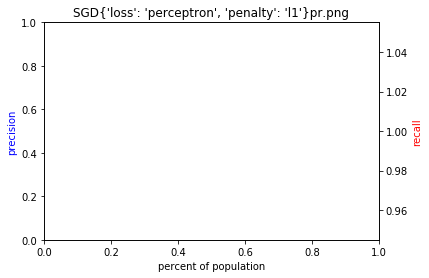

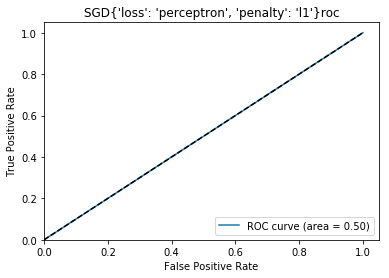

SGD{'loss': 'perceptron', 'penalty': 'elasticnet'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

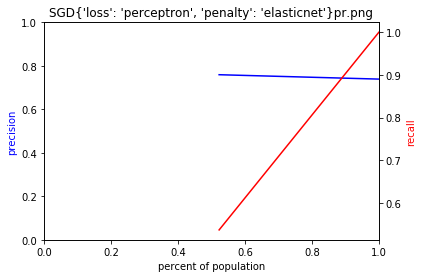

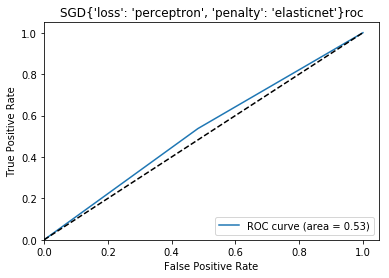

KNN{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

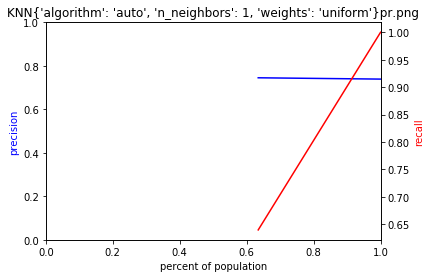

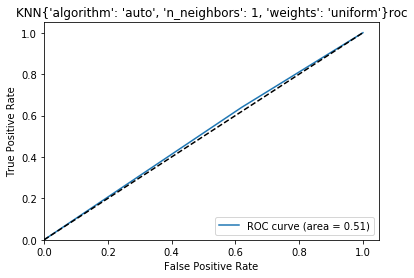

KNN{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'distance'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

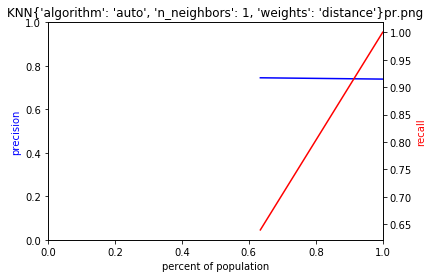

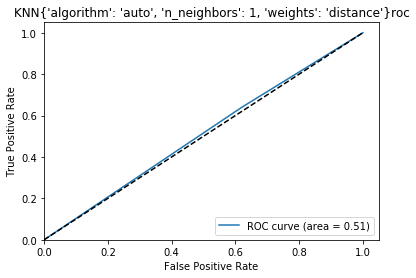

KNN{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

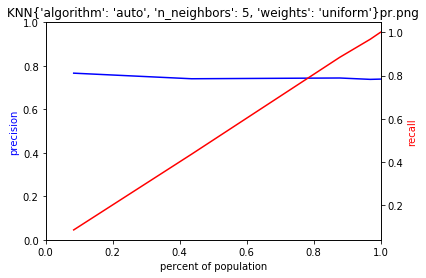

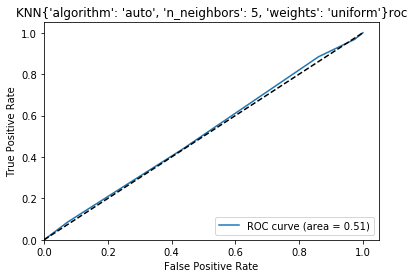

KNN{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

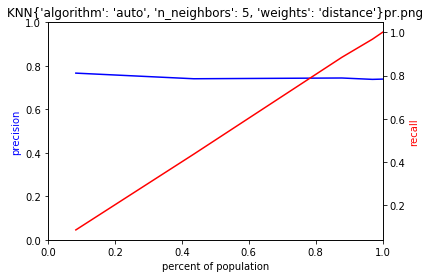

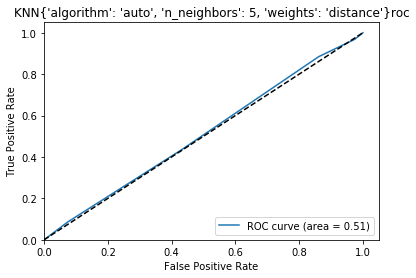

KNN{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

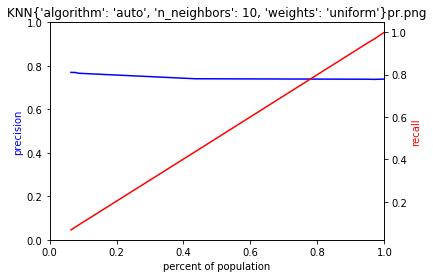

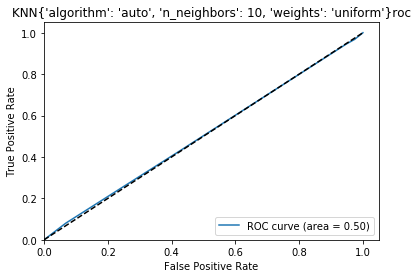

KNN{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

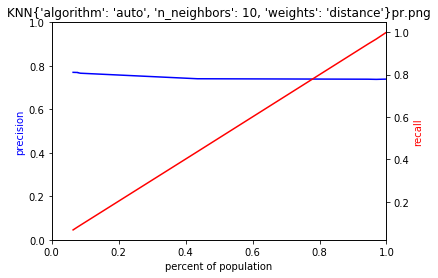

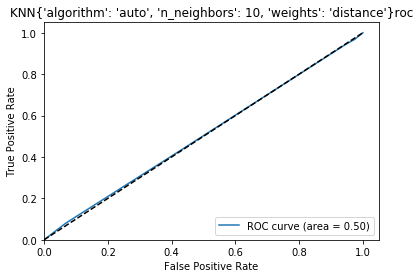

KNN{'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

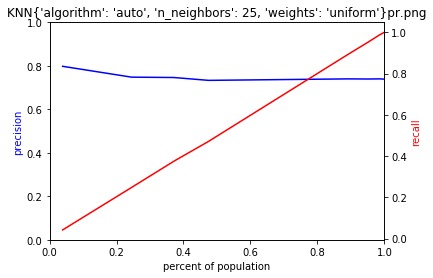

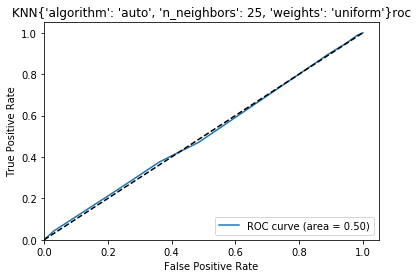

KNN{'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

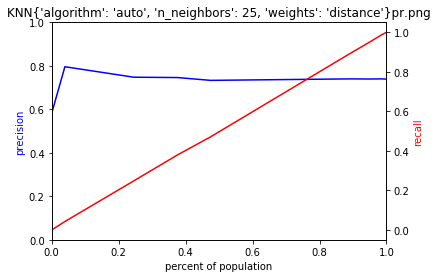

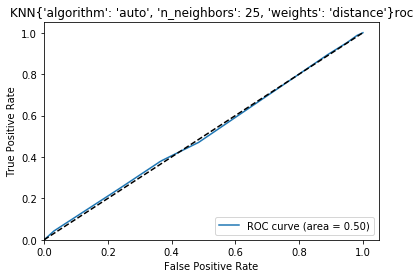

KNN{'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

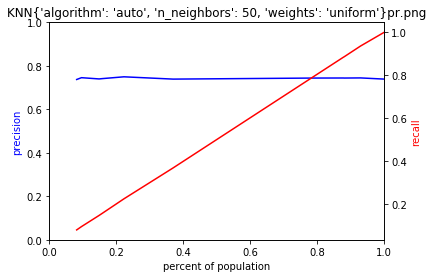

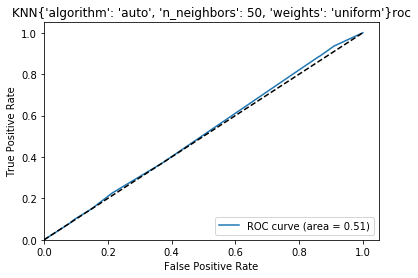

KNN{'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

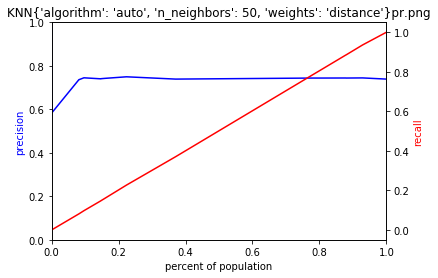

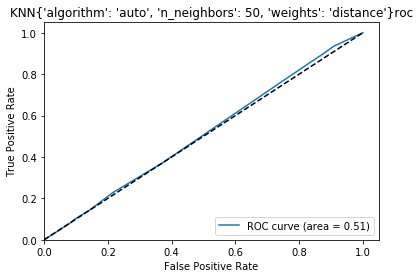

KNN{'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

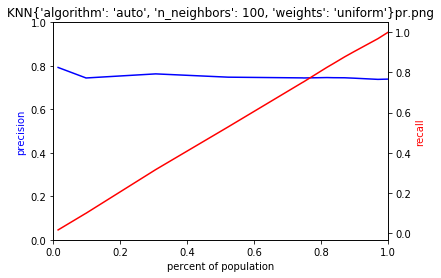

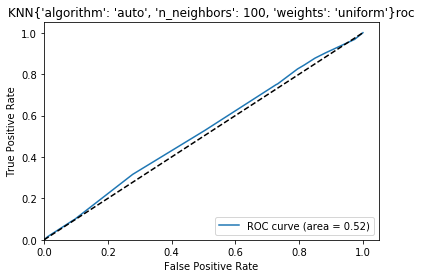

KNN{'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

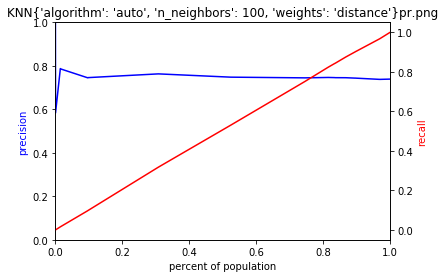

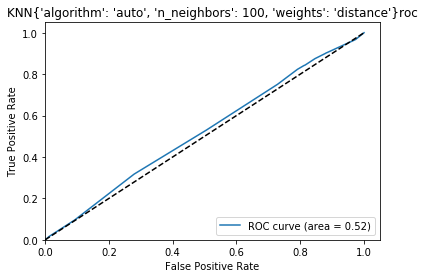

KNN{'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

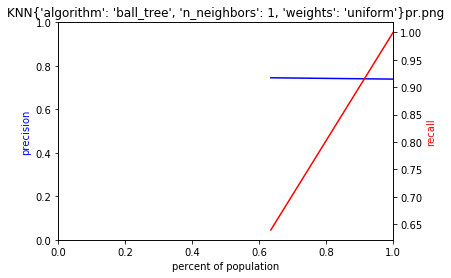

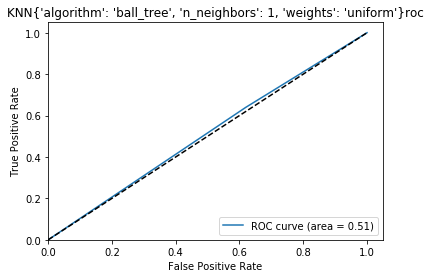

KNN{'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'distance'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

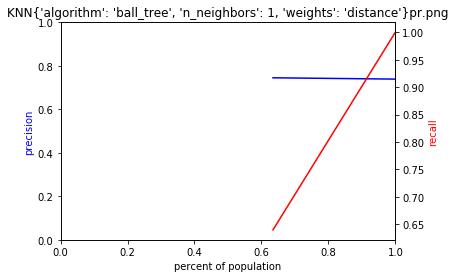

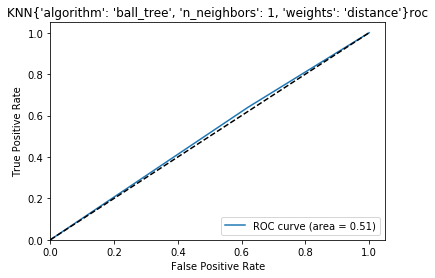

KNN{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

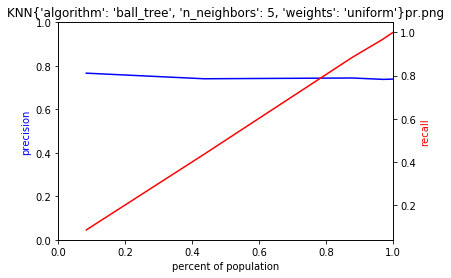

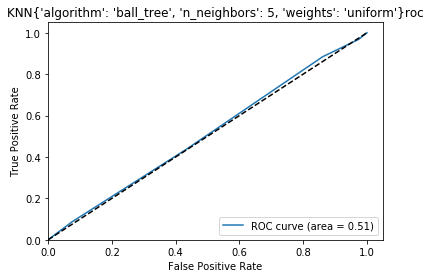

KNN{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

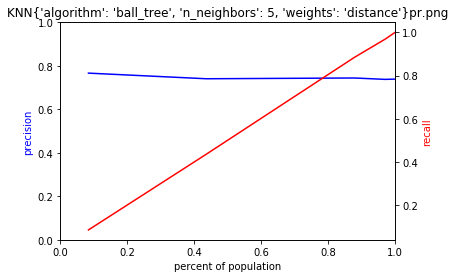

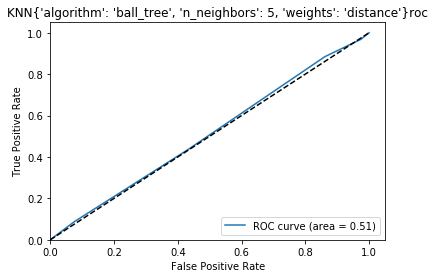

KNN{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

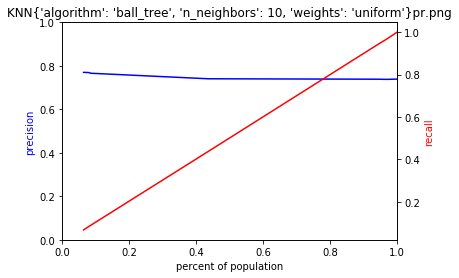

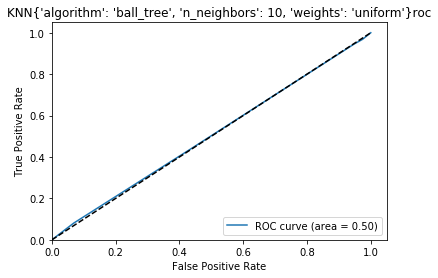

KNN{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

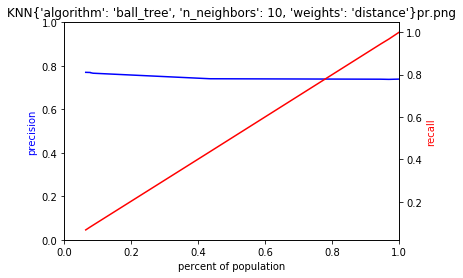

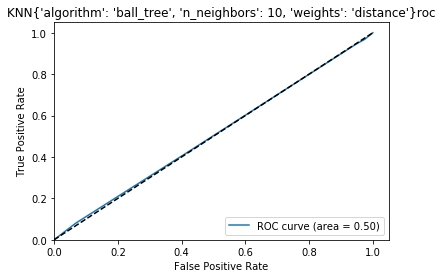

KNN{'algorithm': 'ball_tree', 'n_neighbors': 25, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

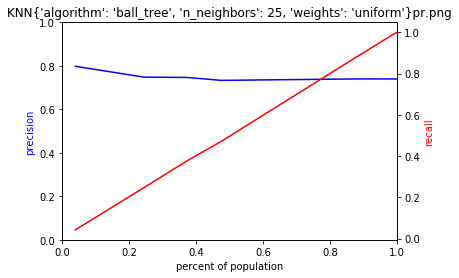

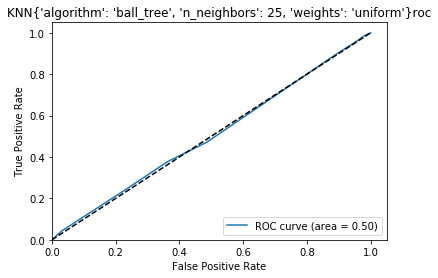

KNN{'algorithm': 'ball_tree', 'n_neighbors': 25, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

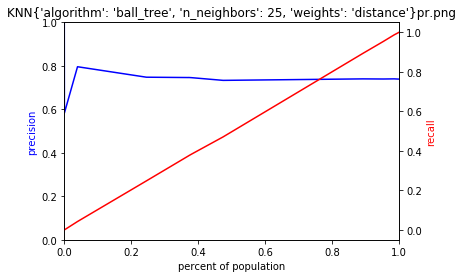

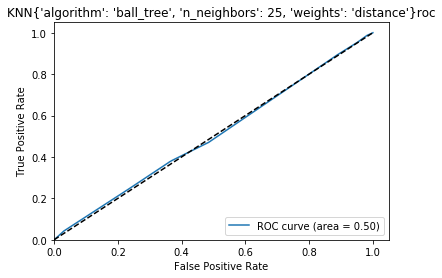

KNN{'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

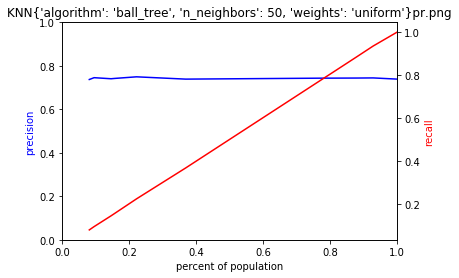

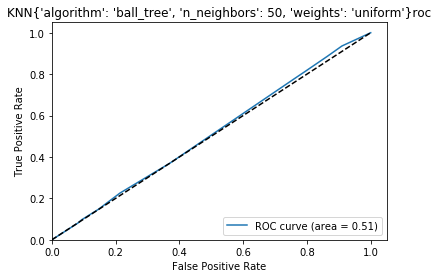

KNN{'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

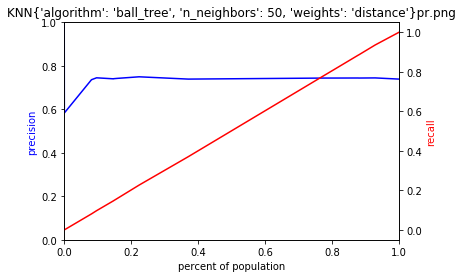

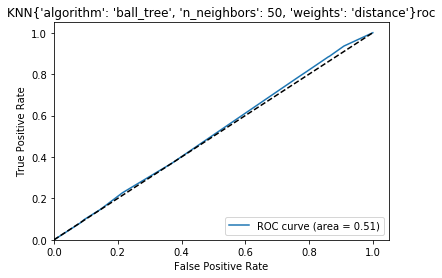

KNN{'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

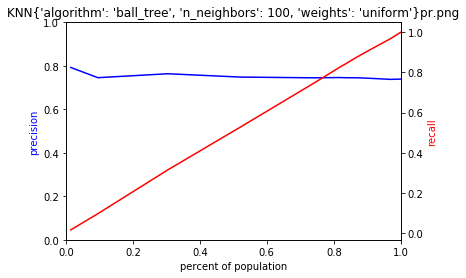

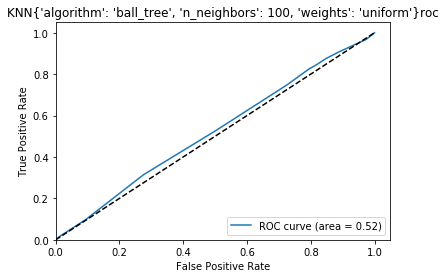

KNN{'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

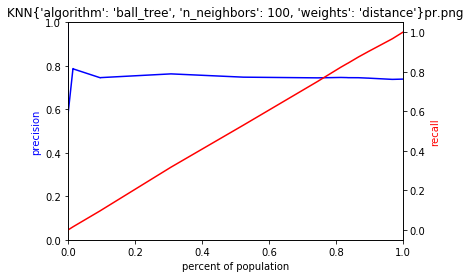

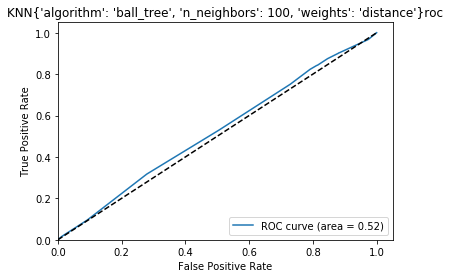

KNN{'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'uniform'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

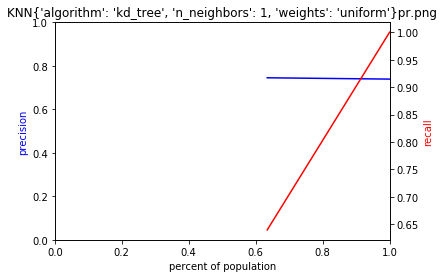

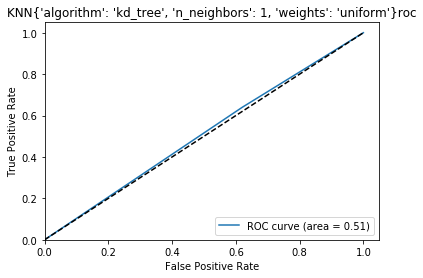

KNN{'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'distance'}


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

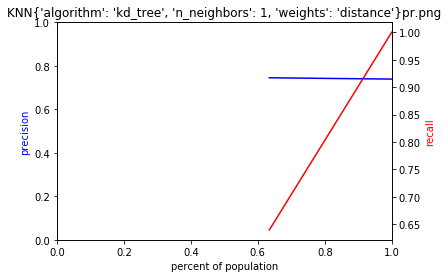

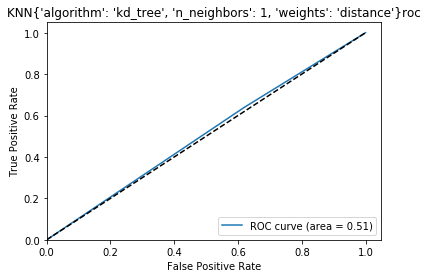

KNN{'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

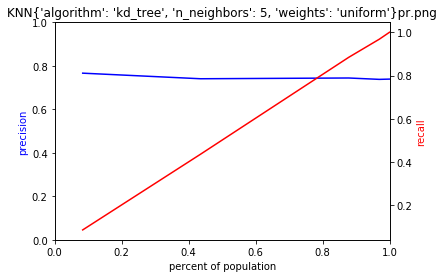

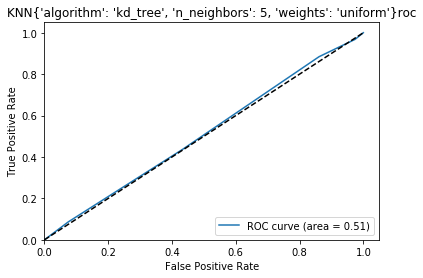

KNN{'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

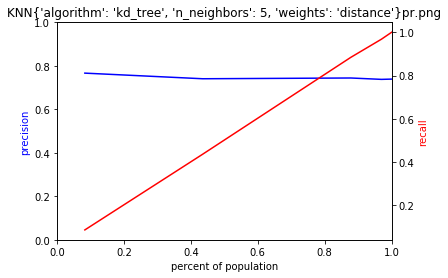

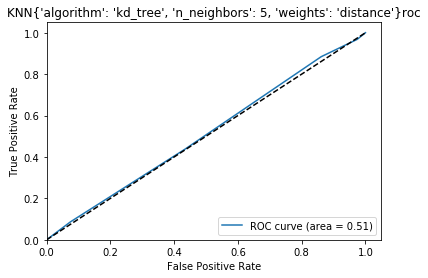

KNN{'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

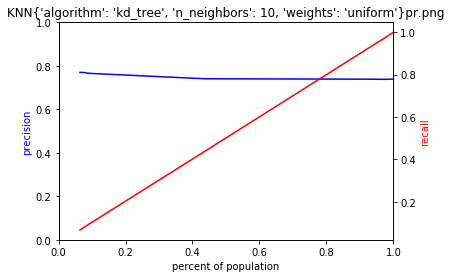

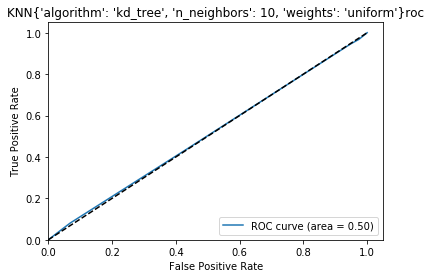

KNN{'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

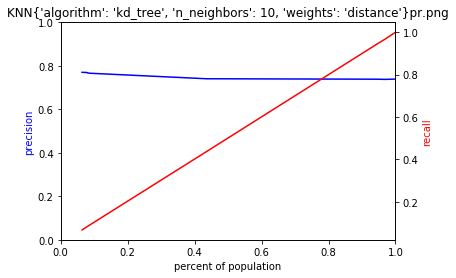

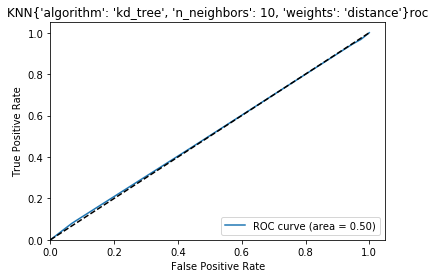

KNN{'algorithm': 'kd_tree', 'n_neighbors': 25, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

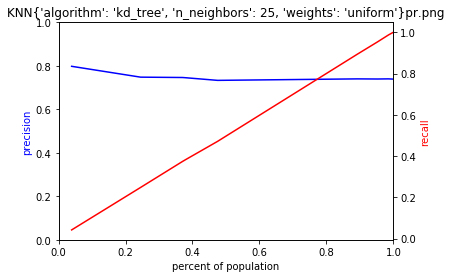

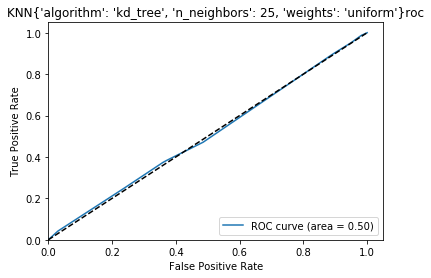

KNN{'algorithm': 'kd_tree', 'n_neighbors': 25, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

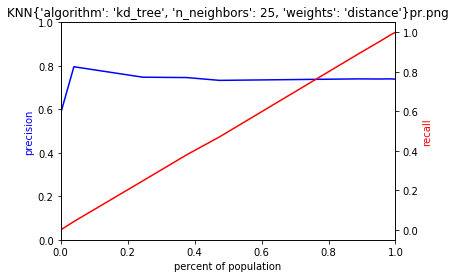

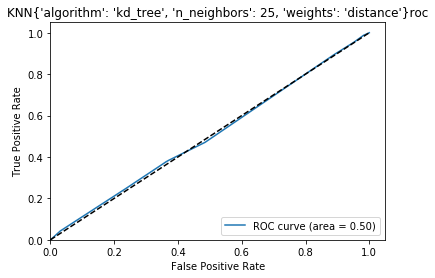

KNN{'algorithm': 'kd_tree', 'n_neighbors': 50, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

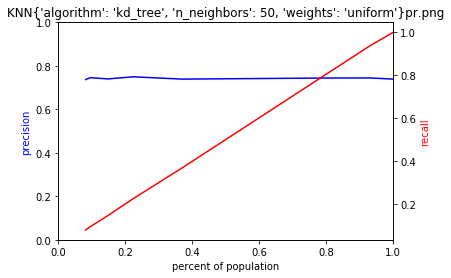

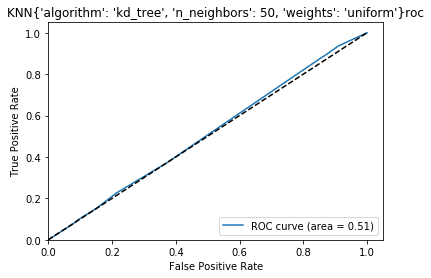

KNN{'algorithm': 'kd_tree', 'n_neighbors': 50, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

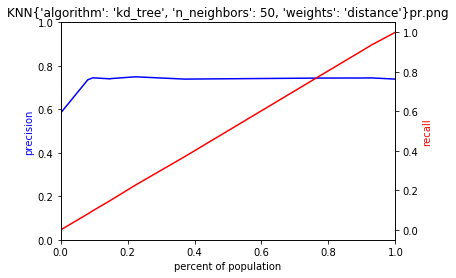

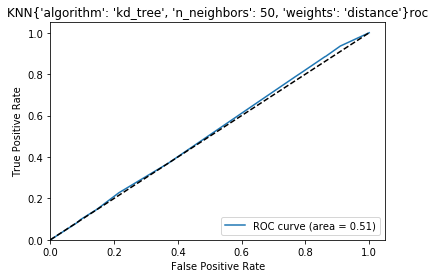

KNN{'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'uniform'}


<Figure size 432x288 with 0 Axes>

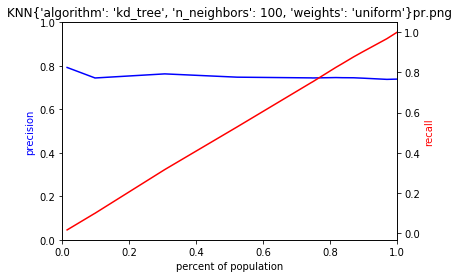

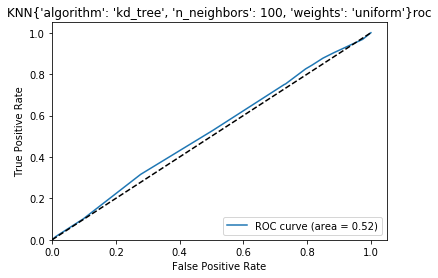

KNN{'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'distance'}


<Figure size 432x288 with 0 Axes>

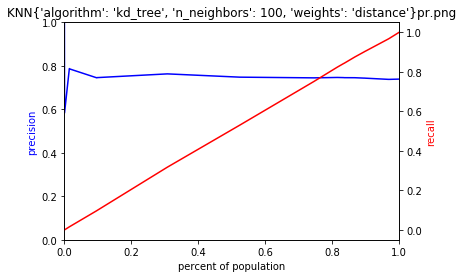

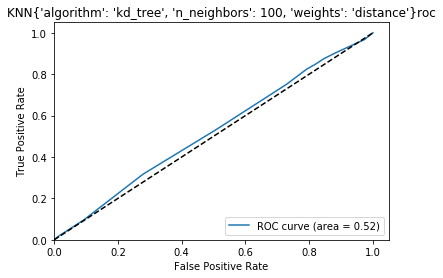

BAG{'max_samples': 0.25, 'n_estimators': 5}


<Figure size 432x288 with 0 Axes>

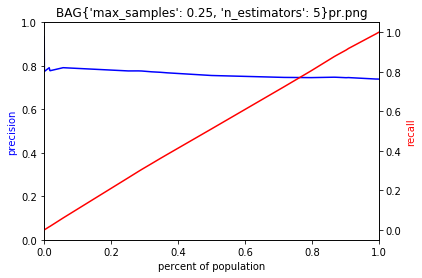

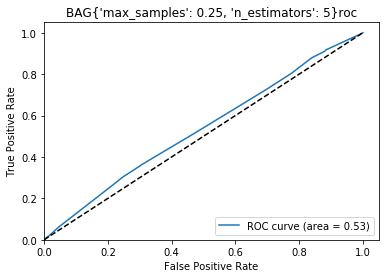

BAG{'max_samples': 0.25, 'n_estimators': 10}


<Figure size 432x288 with 0 Axes>

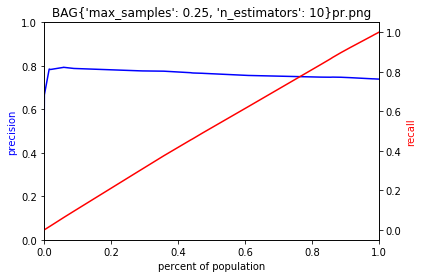

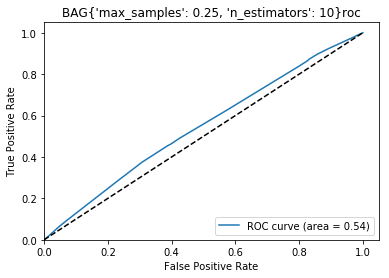

BAG{'max_samples': 0.5, 'n_estimators': 5}


<Figure size 432x288 with 0 Axes>

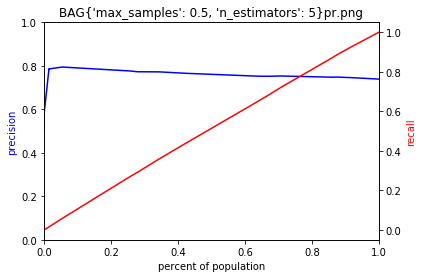

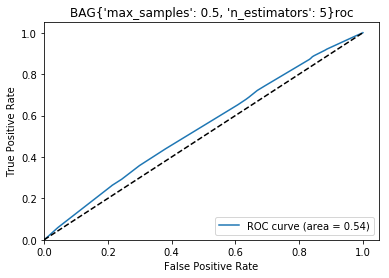

BAG{'max_samples': 0.5, 'n_estimators': 10}


<Figure size 432x288 with 0 Axes>

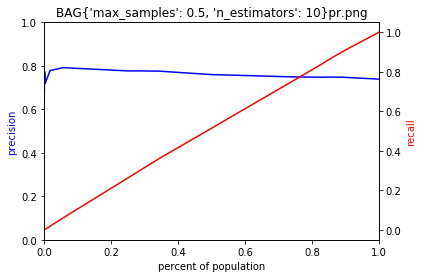

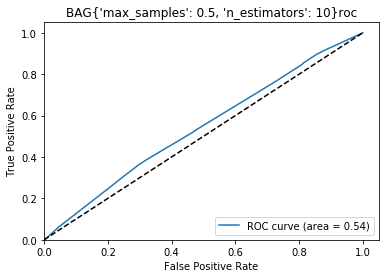

In [61]:
stats, predictions = ml.model_analyzer(clfs, grid, 'show', train_x, list(ready_for_modeling[0][2].values),
                 test_x, list(ready_for_modeling[1][2].values))

In [59]:
grid

{'RF': {'n_estimators': [10, 100],
  'max_depth': [5, 50],
  'max_features': ['sqrt', 'log2'],
  'min_samples_split': [2, 10],
  'n_jobs': [-1]},
 'LR': {'penalty': ['l1', 'l2'],
  'C': [0.001, 0.1, 1],
  'solver': ['lbfgs', 'liblinear']},
 'SGD': {'loss': ['hinge', 'log', 'perceptron'],
  'penalty': ['l2', 'l1', 'elasticnet']},
 'ET': {'n_estimators': [10, 100],
  'criterion': ['gini', 'entropy'],
  'max_depth': [5, 50],
  'max_features': ['sqrt', 'log2'],
  'min_samples_split': [2, 10],
  'n_jobs': [-1]},
 'AB': {'algorithm': ['SAMME', 'SAMME.R'],
  'n_estimators': [1, 10, 100, 1000, 10000]},
 'GB': {'n_estimators': [10, 100],
  'learning_rate': [0.1, 0.5],
  'subsample': [0.5, 1.0],
  'max_depth': [5, 50]},
 'NB': {},
 'DT': {'criterion': ['gini', 'entropy'],
  'max_depth': [1, 5, 10, None],
  'min_samples_split': [2, 5, 10]},
 'SVM': {'C': [0.1], 'kernel': ['linear']},
 'KNN': {'n_neighbors': [1, 5, 10, 25, 50, 100],
  'weights': ['uniform', 'distance'],
  'algorithm': ['auto', 'ba

In [ ]:
for x in stats:
    print(x['model'])
    print('----ACC:', x['accuracy'])
    print('----REC:', x['recall'])
    print('----F1:', x['f1'])

You can run model analyzer with plots='show' to see these plots earlier, or plots='save' to summon them below, with this little loop through the plots/ folder:

In [ ]:
for imageName in glob.glob('plots/*.png'):
    display(Image(filename=imageName))
    print(imageName)

In [ ]:
model_metrics = pd.DataFrame(stats)

In [ ]:
model_metrics.sort_values('accuracy', ascending=False).head(10)